# Mesures quantitatives d'inflation et perception médiatique 
## Projet Python pour la Data-science

### Auteurs : Lise Marchal, Raphaël Pereira et Raphaël Zambélli--Palacio

Ce notebook a pour objectif de présenter les travaux de recherche effectués dans le cadre du cours de Projet Python pour la data-science de la 2A ENSAE.

## Introduction

Ces dernières années, la France, comme de nombreux autres pays, a été confrontée à une crise inflationniste marquée, liée à divers facteurs économiques et géopolitiques. Durant cette période, le sujet de l'inflation et du pouvoir d'achat a été au coeur de nombreux débats et articles dans les médias. Alors que la hausse des prix ralentit actuellement, les débats sur l'inflation et ses implications continuent d'occuper une place  dans les médias et les discussions politiques mais plus secondaire qu'auparavant. Cette situation nous invite à interroger une possible relation entre l'évolution réelle de l'inflation et la manière dont ce phénomène est traité dans les médias.

Une étude récente de la Banque de France, intitulée "Utiliser la presse pour construire un nouvel indicateur de perception d’inflation en France" (Document de travail n°921, 2023, https://www.banque-france.fr/system/files/2023-09/wp921.pdf), explore comment les données textuelles issues des médias peuvent être utilisées pour mesurer la perception publique de l’inflation. En combinant des données de presse et des approches quantitatives, cette recherche propose un nouvel indicateur capable de refléter la sensibilité des médias à ce sujet. Inspirés par cette méthodologie, nous avons cherché à appliquer une approche similaire à un contexte historique en examinant la relation entre taux d’inflation et couverture médiatique aux États-Unis entre 1919 et 1963.

Notre projet vise à répondre à la question suivante : "Les périodes caractérisées par un taux d'inflation élevé coïncident-elles avec celles d’un traitement médiatique accru de cette thématique ?" Pour ce faire, nous nous sommes appuyés sur une base de données complète fournie par la Bibliothèque du Congrès américain, recensant les journaux nationaux et locaux publiés aux USA entre 1919 et 1963. Ce corpus, totalisant plus de 20 Go de données, offre une opportunité unique d’analyser les tendances historiques de la médiatisation de l'inflation aux États-Unis.

Dans un premier temps, nous avons analysé les données économiques contemporaines pour établir les périodes de forte inflation aux États-Unis. Nous avons ensuite collecté et nettoyé les données textuelles afin d’identifier les expression liées à l’inflation dans le corpus. Cette analyse a permis de mettre en correspondance les tendances médiatiques et économiques grâce à des méthodes quantitatives et des visualisations. Enfin, nous avons interprété les résultats pour évaluer les corrélations et les éventuels décalages temporels entre l'inflation réelle et sa médiatisation.

Les résultats préliminaires suggèrent une forte corrélation entre les deux phénomènes, bien que des variations importantes existent selon les périodes et les contextes économiques. Ces conclusions ouvrent des perspectives intéressantes pour mieux comprendre l'interaction entre la réalité économique et son traitement médiatique.


### Problématique : Les périodes caractérisées par un taux d'inflation élevé coïncident-elles avec celles de traitement médiatique accru de cette thématique ?




## Sommaire


- Introduction

- 1- Statistiques descriptives des mesures d'inflation sur la période
  - 1.1- Récupération des données d'inflation de la FED de Saint-Louis
  - 1.2- Traitement des données sur l'inflation

- 2- Analyse de fréquence sur le corpus de presse
  - 2.1- Discussion sur la méthode de détection des articles et analyse descriptive de la BDD d'articles sur l'inflation
  - 2.2- Récupération et formatage des dataframes
  - 2.3- Sélection des termes lexicaux
  - 2.4- Visualisations des fréquences

- 3- Comparaisons de l'inflation mesurée et des fréquences
  - 3.1- Analyse agrégée
  - 3.2- Prolongements

- 4- Modélisation
  - 4.1- Régression linéaire
  - 4.2- Analyse de sentiments

In [4]:
# Imports:

import os
from dotenv import load_dotenv

import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import plotly
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go

from scipy.stats import pearsonr, kendalltau, spearmanr, chi2_contingency, chi2, pointbiserialr
import statsmodels.api as sm

import nltk
nltk.download("stopwords")
nltk.download("wordnet")
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

#from transformers import Trainer, TrainingArguments,AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lisem\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lisem\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Gestion des fichiers avec SSP Cloud

In [5]:
import s3fs
import os

load_dotenv()
fs = s3fs.S3FileSystem(
    client_kwargs={'endpoint_url': 'https://'+'minio.lab.sspcloud.fr'},
    key = os.environ["AWS_ACCESS_KEY_ID"], 
    secret = os.environ["AWS_SECRET_ACCESS_KEY"], 
    token = os.environ["AWS_SESSION_TOKEN"])

MY_BUCKET = "rapamel"
path=f"{MY_BUCKET}/diffusion/ProjetDataScienceInflation"

<a id="1-statistiques-descriptives-des-mesures-dinflation-sur-la-periode"></a>

# 1- Statistiques descriptives des mesures d'inflation sur la période

<a id="#11-recuperation-des-donnees-dinflation-de-la-fed-de-saint-louis"></a>

## 1.1- Récupération des données d'inflation de la FED de Saint-Louis

<a id="111-utilisation-de-lapi-de-la-fred"></a>

### 1.1.1- Utilisation de l'API de la FRED:



La Fed de Saint-Louis met à disposition via son API de nombreuses bases de données d'indicateurs macroéconomiques. Elle offre notamment des séries temporelles couvrant la quasi totalité du XXème siècle ce qui est particulièrement intéressant pour notre projet. En effet, les articles de presse après 1963 ne sont plus en libre accès ce qui a nécessité de se concentrer sur la presse publiée pendant la première moitié du XXème siècle et donc de trouver des séries temporelles d'inflation mesurée sur cette période. Par ailleurs, parmi les nombreuses mesures d'inflation disponibles (ex : inflation sous-jacente, , indices de coûts etc.), nous avons retenu une série assez générale: "Consumer Price Index for All Urban Consumers: All Items in U.S. City Average" ("CPIAUCNS").

In [6]:
# Création de l'URL permettant d'accéder à la série choisie

load_dotenv()
api_root="https://api.stlouisfed.org/fred/series/observations"
series_id="CPIAUCNS"
api_key=os.getenv("FREDToken") # Récupération de la clé d'API dans le fichier .env
file_type="json"

url_api = (
    f"{api_root}?"
    + f"series_id={series_id}&"
    + f"api_key={api_key}&"
    + f"file_type={file_type}"
)

In [7]:
# Lancement de la requête avec l'url créé

req = requests.get(url_api)
wb = req.json()

### 1.1.2- Formatage des données

#### Création et première exploration du dataframe

In [8]:
# Création d'un dataframe à partir du fichier json

CPI_Urban=pd.json_normalize(wb["observations"]) 

In [9]:
CPI_Urban.head()

C:\Users\lisem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\formatters.py:347: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()
C:\Users\lisem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\formatters.py:347: FutureWarning: RangeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()


,realtime_start,realtime_end,date,value
0,2024-12-12,2024-12-12,1913-01-01,9.800
1,2024-12-12,2024-12-12,1913-02-01,9.800
2,2024-12-12,2024-12-12,1913-03-01,9.800
3,2024-12-12,2024-12-12,1913-04-01,9.800
4,2024-12-12,2024-12-12,1913-05-01,9.700


In [10]:
# Sélection des colonnes utiles: date et value
CPI_Urban = CPI_Urban[["date", "value"]]


In [11]:
# Infos générales (1)
CPI_Urban.axes

[RangeIndex(start=0, stop=1343, step=1),
 Index(['date', 'value'], dtype='object')]

In [12]:
# Infos générales (2)
CPI_Urban.dtypes

date     object
value    object
dtype: object

#### Traitement des indices d'inflation

In [13]:
# Conversion du type object vers le type numérique
CPI_Urban['value'] = pd.to_numeric(CPI_Urban['value'], errors='coerce')


#### Traitement des dates

In [14]:
# Conversion en types dates et création des variables années et mois
CPI_Urban['date'] = pd.to_datetime(CPI_Urban['date'])
CPI_Urban['year'] = CPI_Urban['date'].dt.year
CPI_Urban['month'] = CPI_Urban['date'].dt.month

CPI_Urban.head()

C:\Users\lisem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\formatters.py:347: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()
C:\Users\lisem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\formatters.py:347: FutureWarning: RangeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()


,date,value,year,month
0,1913-01-01,9.8,1913,1
1,1913-02-01,9.8,1913,2
2,1913-03-01,9.8,1913,3
3,1913-04-01,9.8,1913,4
4,1913-05-01,9.7,1913,5


#### Création de la variable pourcentage d'inflation annuelle ("inf_an") : 

Le jeu de données se présente sous la forme d'indices avec une base 100 en 1983. Le choix a cependant été fait de réaliser l'analyse sur des pourcentages d'inflation. On crée donc la variable inf_an, qui correspond au pourcentage d'inflation calculé par rapport au niveau de l'indice de prix douze mois plus tôt. 
$$
    \frac{indice_t - indice_{t-12}}{indice_{t-12}}*100
$$

On relèvera cependant une limite : il n'est pas idéal d'avoir la date de la base 100 postérieure à la période étudiée ouisque le panier de biens et services considéré peut s'avérer moins pertinent à des dates très antérieures.  

In [15]:
# Inflation annuelle: ((indice/indice 12 mois auparavant)-1)*100
CPI_Urban['inf_an']=((CPI_Urban['value']-CPI_Urban['value'].shift(12))/CPI_Urban['value'].shift(12))*100
CPI_Urban.head(20)

C:\Users\lisem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\formatters.py:347: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()
C:\Users\lisem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\formatters.py:347: FutureWarning: RangeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()


,date,value,year,month,inf_an
0,1913-01-01,9.8,1913,1,NaN
1,1913-02-01,9.8,1913,2,NaN
2,1913-03-01,9.8,1913,3,NaN
3,1913-04-01,9.8,1913,4,NaN
4,1913-05-01,9.7,1913,5,NaN
5,1913-06-01,9.8,1913,6,NaN
6,1913-07-01,9.9,1913,7,NaN
7,1913-08-01,9.9,1913,8,NaN
8,1913-09-01,10.0,1913,9,NaN
9,1913-10-01,10.0,1913,10,NaN


#### Création d'un sous-tableau de la période considérée (1919-1962)

In [16]:
CPI_sub = CPI_Urban[(CPI_Urban['year'] > 1918) & (CPI_Urban['year'] < 1963)]
CPI_sub.head()


C:\Users\lisem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\formatters.py:347: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()


,date,value,year,month,inf_an
72,1919-01-01,16.5,1919,1,17.857143
73,1919-02-01,16.2,1919,2,14.893617
74,1919-03-01,16.4,1919,3,17.142857
75,1919-04-01,16.7,1919,4,17.605634
76,1919-05-01,16.9,1919,5,16.551724


In [17]:
CPI_sub.tail()

C:\Users\lisem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\formatters.py:347: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()


,date,value,year,month,inf_an
595,1962-08-01,30.3,1962,8,1.337793
596,1962-09-01,30.4,1962,9,1.333333
597,1962-10-01,30.4,1962,10,1.333333
598,1962-11-01,30.4,1962,11,1.333333
599,1962-12-01,30.4,1962,12,1.333333


<a id="12-traitement-des-donnees-sur-linflation"></a>


## 1.2- Traitement des données sur l'inflation

<a id="121-premieres-statistiques-descriptives"></a>


### 1.2.1- Premières statistiques descriptives sur l'inflation pendant la période

#### Premières statistiques sur l'ensemble du dataframe (1919-1962)

In [18]:
CPI_sub['inf_an'].describe()

count    528.000000
mean       1.781563
std        6.051345
min      -15.789474
25%       -0.700532
50%        1.355948
75%        3.361353
max       23.668639
Name: inf_an, dtype: float64

Grâce à ces premières statistiques, on peut déjà constater que l'inflation annuelle moyenne entre 1919 et 1962 est positive. Elle est de plus relativement proche des cibles d'inflation contemporaines (environ 1.8%). La volatilité est élevée, l'écart-type s'élevant à 6.1%. Sur la période considérée le pourcentage d'inflation minimum s'est élevé à -15.8%, tandis que le pourcentage d'inflation maximum a culminé à 23.7%. Ces niveaux sont respectivement bien inférieurs et supérieurs à ceux observés dans les décennies plus récentes. Enfin, le pourcentage d'inflation annuel médian est inférieur au pourcentage d'inflation moyenne ce qui indique une distribution plus dispersée vers le haut. 

#### Figure 1: Evolution du pourcentage d'inflation annuelle par mois sur l'ensemble de la période

In [19]:
# Création d'une fonction de base pour la création de graphiques en courbe

def line_graph (df, abs, ord, titre, x_title, x_format, y_title, val_rem):
    """
    Fonction traçant un graphique en courbe interactif.
    ==================================================
    Paramètres:
    ==================================================
    df: dataframe d'où sont issues les données
    abs: série sur l'axe des abcisses
    ord: série sur l'axe des ordonnées
    titre: titre du graphique
    x_title: nom de l'axe des abcisses
    y_title: nom de l'axe des ordonnées
    val_rem: booléen indiquant si l'on souhaite ou non l'affichage des valeurs remarquables (0, moyenne, médiane)
    """

    # Création du graphique
    graph = px.line(
        df, 
        x=abs, 
        y=ord, 
        title=titre,
        labels={abs: x_title, ord:y_title}
    )
    # Légende et format des axes
    graph.update_xaxes(title=x_title, tickformat=x_format)
    graph.update_yaxes(title=y_title)

    # Style du graphique
    graph.update_layout(template="plotly_dark")

    # Mise en évidence des valeurs remarquables (moyenne et médiane)
    if val_rem==True:
        mean=df[ord].mean()
        median=df[ord].median()
        
        graph.add_hline(y=mean, line_dash="dot", line_color="yellow", annotation_text="Moyenne", annotation_position="top left", annotation_font_color="yellow")
        graph.add_hline(y=median, line_dash="dot", line_color="white", annotation_text="Médiane", annotation_position="bottom right", annotation_font_color="white")
        graph.add_hline(y=0, line_color="red")

    graph.show(config={"scrollZoom": True, "displayModeBar": True})

    
    

In [20]:
line_graph (
    CPI_sub, 
    "date", 
    "inf_an", 
    "Figure 1: Pourcentage d'inflation annuelle de 1919 à 1962", 
    "Date", 
    "%m-%Y", 
    "Inflation (%)",
    True
)

On observe une **première période de très forte inflation** dans l'immédiat après-guerre. L'inflation est en effet comprise entre 13.5% et 23,7%, niveau maximum sur l'ensemble de notre période d'étude, atteint en juin 1920. Cette période est suivie de la **première période de déflation**, de janvier 1921 à février 1923. La déflation la plus forte de la période a lieu en juin 1921 (-15.8%). Après une relative stabilité dans les années 20, la crise des années 30 engendre une **deuxième période de déflation**, de mai 1930 à novembre 1933, l'inflation restant autour de -9.5% pendant deux ans. L'inflation reste ensuite faible jusqu'à la Seconde Guerre mondiale. Celle-ci se caractérise par une **deuxième période d'inflation**, avec un pic à 13.2% en mai 1942. Cependant, cette période est assez courte, la moyenn'inflation retrouvant son niveau moyen de longue période dès le début de 1944. L'après-guerre constitue en revanche une **troisième période de forte inflation**, avec un pic à 19.7%. La fin de la période, notamment à partir de 1952, se caractérise elle par un **stabilisation de l'inflation à des niveaux faibles**, autour de la médiane à 1.4%. 

<a id="122-identification-de-periodes-dinteret"></a>


### 1.2.2- Identification de périodes d'intérêt

#### Identification des périodes d'inflation négative

##### Création d'une indicatrice prenant la valeur 1 si l'inflation est négative et 0 sinon

In [21]:
# Création d'une indicatrice inf_neg qui prend la valeur 1 si l'inflation est négative et 0 sinon
CPI_sub.loc[:,'inf_neg']=0
CPI_sub.loc[CPI_sub['inf_an'] < 0, 'inf_neg'] = 1
CPI_sub.head(30)

C:\Users\lisem\AppData\Local\Temp\ipykernel_35644\1604323234.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\formatters.py:347: FutureWarning:

Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.



,date,value,year,month,inf_an,inf_neg
72,1919-01-01,16.5,1919,1,17.857143,0
73,1919-02-01,16.2,1919,2,14.893617,0
74,1919-03-01,16.4,1919,3,17.142857,0
75,1919-04-01,16.7,1919,4,17.605634,0
76,1919-05-01,16.9,1919,5,16.551724,0
77,1919-06-01,16.9,1919,6,14.965986,0
78,1919-07-01,17.4,1919,7,15.231788,0
79,1919-08-01,17.7,1919,8,14.935065,0
80,1919-09-01,17.8,1919,9,13.375796,0
81,1919-10-01,18.1,1919,10,13.125000,0


##### Quelques statistiques sur les périodes d'inflation négative

In [22]:
CPI_sub[CPI_sub['inf_neg'] == 1]['inf_an'].describe()

count    156.000000
mean      -4.190409
std        4.039146
min      -15.789474
25%       -7.702932
50%       -2.240914
75%       -1.048073
max       -0.371747
Name: inf_an, dtype: float64

On a donc 156 mois de déflation contre 372 mois d'inflation positive sur la période 1919-1962. Les mois de déflation sont largement concentrés avant la Seconde Guerre mondiale (Cf. Figure 2). La moyenne du pourcentage d'inflation sur ces périodes de déflations est assez basse (-4.2%), significativement inférieure à la médiane (-2.2%), du fait du nombre important d'observations très négatives. 

##### Figure 2: Représentation des périodes d'inflation négative de 1919 à 1962

In [47]:
def bar_graph(df,abs,ord,titre, x_title, y_title, ori):
    """
    Fonction traçant un diagramme à barres.
    =======================================
    Paramètres
    =======================================
    df: dataframe d'où sont issues les données
    abs: série sur l'axe des abcisses
    ord: série sur l'axe des ordonnées
    titre: titre du graphique
    x_title: nom de l'axe des abcisses
    y_title: nom de l'axe des ordonnées
    ori: orientation des barres, 'v' pour vertical, 'h' pour horizontal
    """

    graph=px.bar(
                df, 
                x=abs, 
                y=ord, 
                title=titre,
                labels={abs: x_title, ord:y_title},
                orientation=ori
                
            )

    graph.update_layout(template="plotly_dark")

    graph.show(config={"scrollZoom": True, "displayModeBar": True})

In [48]:
bar_graph(
    CPI_sub,
    'date',
    'inf_neg',
    "Figure 2: Représentation des périodes d'inflation négative de 1919 à 1962",
    'Date',
    'Inflation négative',
    'v'
)

#### Identification des périodes d'accélération et de décélération

Pour mesurer l'accélération et la décélération de l'inflation, le choix a été fait de s'intéresser à la différence entre l'inflation observée un mois donné et le pourcentage d'inflation douze mois auparavant.
En raison du nombre important de valeurs négatives, l'échelle logarithmique n'a pas été retenue malgré les avantages qu'elle aurait eu, notamment en raison des forts pourcentages d'évolution. Le choix de calculer des taux de croissance pose néanmoins le problème des valeurs d'inflation nulles dues à des arrondis. On les remplace par les moyennes des valeurs immédiatement précédente et suivante pour lisser la représentation lorsqu'elles sont isolées, sinon par les valeurs non nulles immédiatement précédente ou suivante. 

##### Création de la variable acceleration_12 (pourcentage d'accélération)

In [24]:
# Création du pourcentage d'évolution de l'inflation
CPI_sub.loc[:, 'acceleration_12'] = (CPI_sub.loc[:,'inf_an']/CPI_sub.loc[:,'inf_an'].shift(12) - 1)*100 
CPI_sub.head(30)


C:\Users\lisem\AppData\Local\Temp\ipykernel_35644\750671830.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\formatters.py:347: FutureWarning:

Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.



,date,value,year,month,inf_an,inf_neg,acceleration_12
72,1919-01-01,16.5,1919,1,17.857143,0,NaN
73,1919-02-01,16.2,1919,2,14.893617,0,NaN
74,1919-03-01,16.4,1919,3,17.142857,0,NaN
75,1919-04-01,16.7,1919,4,17.605634,0,NaN
76,1919-05-01,16.9,1919,5,16.551724,0,NaN
77,1919-06-01,16.9,1919,6,14.965986,0,NaN
78,1919-07-01,17.4,1919,7,15.231788,0,NaN
79,1919-08-01,17.7,1919,8,14.935065,0,NaN
80,1919-09-01,17.8,1919,9,13.375796,0,NaN
81,1919-10-01,18.1,1919,10,13.125000,0,NaN


In [25]:
# Traitement des pourcentages d'évolution infinis

# On le fait un nb arbitraire de fois pour traiter les cas de 3,4,5,6 valeurs infinies se suivant. 
# On ne fait pas une boucle while par exemple sur la moyenne pour éviter les boucles infinies

for i in range(5):
    # traitement des valeurs infinies isolées: remplacement par la moyenne entre la valeur précédente et la valeur suivante
    CPI_sub.loc[
        abs(CPI_sub["acceleration_12"]) == np.inf,
        "acceleration_12"
    ] = (CPI_sub["acceleration_12"].shift(1) + CPI_sub["acceleration_12"].shift(-1)) / 2
    #traitement des valeurs infinies suivies de valeurs infinies: remplacement par la valeur précédente
    CPI_sub.loc[
        (abs(CPI_sub["acceleration_12"]) == np.inf) & (abs(CPI_sub["acceleration_12"].shift(-1)) == np.inf),
        "acceleration_12"
    ] = CPI_sub["acceleration_12"].shift(1)

    #traitement des valeurs infinies précédées de valeurs infinies: remplacement par la valeur suivante
    CPI_sub.loc[
        (abs(CPI_sub["acceleration_12"]) == np.inf) & (abs(CPI_sub["acceleration_12"].shift(1)) == np.inf),
        "acceleration_12"
    ] = CPI_sub["acceleration_12"].shift(-1)

CPI_sub.head(20)



C:\Users\lisem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\formatters.py:347: FutureWarning:

Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.



,date,value,year,month,inf_an,inf_neg,acceleration_12
72,1919-01-01,16.5,1919,1,17.857143,0,NaN
73,1919-02-01,16.2,1919,2,14.893617,0,NaN
74,1919-03-01,16.4,1919,3,17.142857,0,NaN
75,1919-04-01,16.7,1919,4,17.605634,0,NaN
76,1919-05-01,16.9,1919,5,16.551724,0,NaN
77,1919-06-01,16.9,1919,6,14.965986,0,NaN
78,1919-07-01,17.4,1919,7,15.231788,0,NaN
79,1919-08-01,17.7,1919,8,14.935065,0,NaN
80,1919-09-01,17.8,1919,9,13.375796,0,NaN
81,1919-10-01,18.1,1919,10,13.125000,0,NaN


##### Figure 3: Pourcentage d'accélération de l'inflation annuelle par mois de 1920 à 1962

In [26]:
line_graph (
    CPI_sub, 
    "date", 
    "acceleration_12", 
    "Figure 3: Pourcentage d'accélération de l'inflation annuelle par mois de 1920 à 1962", 
    "Date", 
    "%m-%Y", 
    "Accélération (%)",
    False
)

On constate que les périodes d'accélération et de décélération sont souvent les mêmes, correspondant en fait à quatre pics de volatilité, avec des pourcentages d'accélération qui dépassent le seuil de 1000% en valeur absolue : autour de 1931, de 1941, de 1947 et de 1951. Ils correspondent donc tous à des périodes de forte inflation ou de déflation accentuée.

# 2- Analyse de fréquence sur le corpus de presse

## 2.1- Discussion sur la méthode de détection des articles et analyse descriptive de la BDD d'articles sur l'inflation

**Note**: En raison du temps d'exécution important nécessaire à la réalisation des fichiers csv. de fréquence d'occurence des termes liés au champs lexical de l'inflation, ceux-ci sont générés à part et seulement importés ici.

Ce notebok, nommé "Analyse_NLP_frequentielle", est un codebook annexe contenant toutes les fonctions nécessaires à cette étape du code. Il permet de récupérer un dictionnaire contenant pour chaque mois, le nombre d'articles ainsi que, pour chaque expression liée à l'inflation, le nombre d'articles sur le mois contenant l'expression.

Il est conseillé d'aller voir ce notebook car il permet de bien comprendre comment nous avons obtenu ces résultats. Comme son temps d'exécution est très conséquent, vous pouvez le tester sur une année seulement au lieu de tout le corpus, ce qui prend un temps raisonnable (environ 7 minutes). Pour plus de détails, aller voir le notebook en question.

**Choix des expressions**: Pour détecter quel article parle d'inflation, nous nous sommes inspirés de l'article de recherche fait par la Banque de France (https://www.banque-france.fr/system/files/2023-09/wp921.pdf) qui avait pour objectif de construire un indicateur d'inflation perçu en France à partir des articles de presse et de Tweeter. Dans un premier temps, ils ont élaboré une liste d'expressions pouvant être liée à l'inflation.

Leur méthode a été de prendre des mots assez large comme "price" ou encore "tabac" pour faire un premier filtre avant de faire un second filtrage à l'aide d'outils de classification supervisée.

Comme nous ne pensions pas faire de second filtrage, nous avons décidé de restreindre un peu les expressions choisies. On a tout de même gardé un éventail assez large, quitte à faire un tri dans les expressions que l'on analysera par la suite.

Une dernière différence par rapport aux choix des expressions est la présence de 2-gram et 3-gram. En effet, nous avons ajouté des expressions à 2 mots et 3 mots (comme "cost of living"), considérant qu'elles pourraient potentiellement apporter des informations.

NotaBene : Les expressions sont uniquement en minuscule, pour éviter de rater les articles parlant d'inflation mais dont le terme "Inflation" serait en majuscule, nous transformons le texte des articles en minuscule lors de l'analyse (voir le codebook annexe)

In [27]:
def creer_dictionnaire_inflation():
    #Cette fonction renvoie un dictionnaire de n-gram relatifs à l'inflation et aux prix

    dictionnaire = {
        "1-gram": [
            "inflation", "disinflation", "inflationary", "deflation", "prices", "cost", "wages", "currency",
            "money", "devaluation","recession", "stagflation", "economy", "market", "increase", "decrease", "cpi"
        ],
        "2-gram": [
            "price level", "wage growth", "economic downturn", "monetary policy",
            "cost increase", "cost reduction", "inflation expectations", "market prices", "inflation rate",
            "interest rates", "price stability", "consumption basket", "purchasing power"
        ],
        "3-gram": [
            "consumer price index", "rise in prices", "fall in prices",
            "cost of living", "money supply growth",
            "central bank policy", "economic price adjustments"
        ]
    }
    return dictionnaire

dictionnaire_inflation = creer_dictionnaire_inflation()

En appliquant les fonctions du codebook annexe, on obtient deux types de fichier :

- Les fichiers frequences_data en .csv qui sont dans ce Git, qui contiennent les occurences mensuelles de chaque expression du dictionnaire ci-dessus dans le corpus de texte avec en plus le nombre d'articles dans le corpus pour chaque mois

- Le fichier AllInflation.parquet, qui est stocké via S3, qui contient l'ensemble des textes contenant au moins une expression liée à l'inflation.

Avant de commencer à regarder et analyser les résultats sur les occurrences des expressions, prenons un temps pour décrire la base de données d'articles contenant au moins une expression liée à l'inflation

On regarde uniquement le corpus d'articles contenant au moins un terme du dictionnaire d'inflation, les autres résultats (occurrences et fréquences par rapport au nombre de texte du corpus total) seront détaillés dans la prochaine partie

In [28]:
#On importe le fichier qui se trouve stocké sur S3

#Le fichier s'exécute en moins de 2 minutes
with fs.open(path + "/AllInflation.parquet", "rb") as file_in:
    data_articles_inflation = pd.read_parquet(file_in)

In [29]:

def dereference_dico(dico):
    return dico["article"]
data_articles_inflation["Article"]=data_articles_inflation["Article"].apply(dereference_dico)


#### A/ Premières observations

In [30]:
data_articles_inflation.head()

C:\Users\lisem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\formatters.py:347: FutureWarning:

Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.



,Title,Date,Article
0,The commoner.,1919-01,BEST MAKES OF guaranteed tires at\n\n\nless th...
1,The commoner.,1919-01,MAKE YOUR WALL PAPER clean and\n\n\nsweet agai...
2,The commoner.,1919-01,"STORIES. POEMS, PLAYS. ETC., are\n\n\nwanted f..."
3,New Britain herald.,1919-01,VV1ANTED-An experienced man on punch press and...
4,New Britain herald.,1919-01,Have you lost a sum of money? Glasses. Pins an...


In [31]:
nombre_observations = data_articles_inflation.shape[0]
years_range = (data_articles_inflation['Date'].min(), data_articles_inflation['Date'].max())
unique_journals = data_articles_inflation['Title'].nunique()

print(f"Cette base de données contient {nombre_observations} articles de presse publiés entre {years_range[0]} et {years_range[1]}. ")
print(f"Elle comprend {unique_journals} journaux différents. Voici un aperçu des données disponibles :")
print(data_articles_inflation.head())


Cette base de données contient 3957020 articles de presse publiés entre 1919-01 et 1962-12. 
Elle comprend 570 journaux différents. Voici un aperçu des données disponibles :
                 Title     Date  \
0        The commoner.  1919-01   
1        The commoner.  1919-01   
2        The commoner.  1919-01   
3  New Britain herald.  1919-01   
4  New Britain herald.  1919-01   

                                             Article  
0  BEST MAKES OF guaranteed tires at\n\n\nless th...  
1  MAKE YOUR WALL PAPER clean and\n\n\nsweet agai...  
2  STORIES. POEMS, PLAYS. ETC., are\n\n\nwanted f...  
3  VV1ANTED-An experienced man on punch press and...  
4  Have you lost a sum of money? Glasses. Pins an...  


#### B/ Analyse en détails du corpus

On regarde ci-dessous trois informations : Le nombre d'articles par date, le nombre d'articles provenant d'un même journal, et la longueur moyenne d'un article pour chaque journal

In [32]:
"""
data_articles_inflation['year_month'] = pd.to_datetime(data_articles_inflation['Date'], format='%Y-%m')
articles_per_date = data_articles_inflation.groupby('year_month').size()
line_graph(
    articles_per_date, 
    "year_month", 
    "acceleration_12", 
    "Nombre d'articles par date", 
    "Date", 
    "%m-%Y", 
    "Nb d'articles",
    False
)
"""

'\ndata_articles_inflation[\'year_month\'] = pd.to_datetime(data_articles_inflation[\'Date\'], format=\'%Y-%m\')\narticles_per_date = data_articles_inflation.groupby(\'year_month\').size()\nline_graph(\n    articles_per_date, \n    "year_month", \n    "acceleration_12", \n    "Nombre d\'articles par date", \n    "Date", \n    "%m-%Y", \n    "Nb d\'articles",\n    False\n)\n'

In [43]:
data_articles_inflation['year_month'] = pd.to_datetime(data_articles_inflation['Date'], format='%Y-%m')
articles_per_date = data_articles_inflation.groupby('year_month').size()
df_articles_per_date =articles_per_date.to_frame(name='nb')
df_articles_per_date=df_articles_per_date.reset_index()
df_articles_per_date.head()


C:\Users\lisem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\formatters.py:347: FutureWarning:

Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.

C:\Users\lisem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\formatters.py:347: FutureWarning:

RangeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.



,year_month,nb
0,1919-01-01,27709
1,1919-02-01,24027
2,1919-03-01,27738
3,1919-04-01,28503
4,1919-05-01,26451


In [45]:
line_graph(
    df_articles_per_date, 
    "year_month", 
    "nb", 
    "Nombre d'articles par date", 
    "Date", 
    "%Y", 
    "Nb d'articles",
    False
)

Avec ce graphique, on remarque que le nombre d'articles sur la période 1919-1923 est largement plus élevé que sur les autres périodes. Cela s'explique par le fait que dans le corpus initial (celui du Congrès Américain), cette période contient bien plus d'articles que les autres périodes.
Cette différence de nombre de texte au cours du temps n'est en aucun cas un obstacle pour la suite car nous allons analyser les fréquences des articles parlant d'inflation sur le nombre d'articles total sur la période considérée.

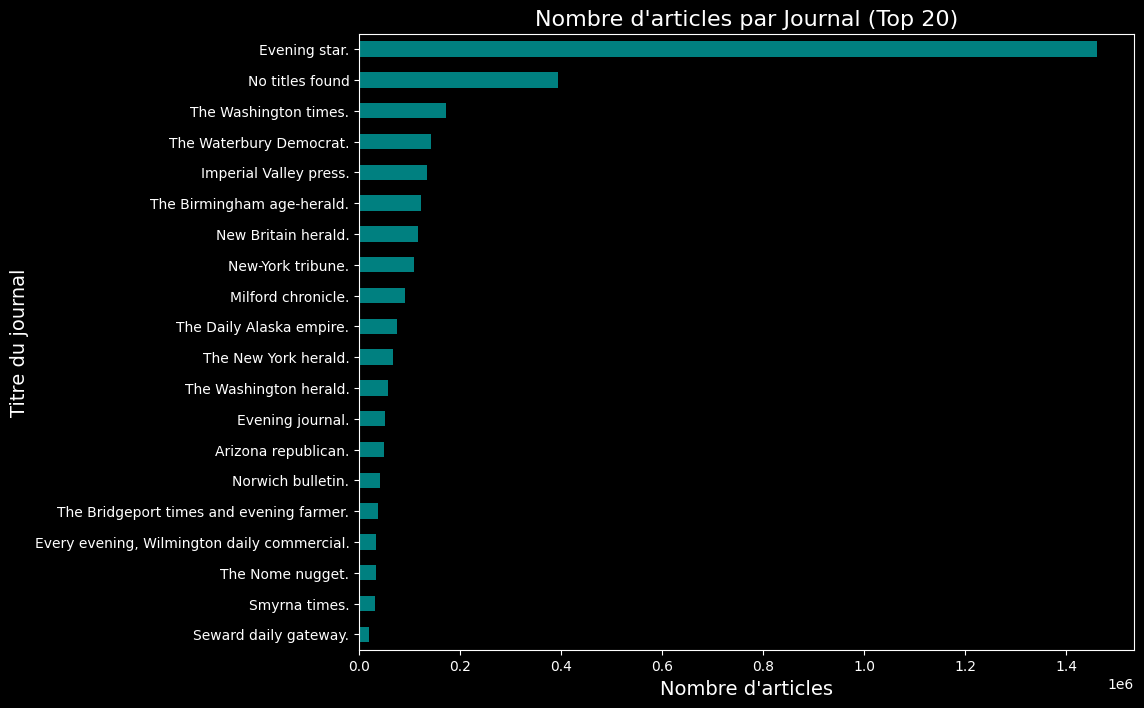

In [66]:
articles_per_journal = data_articles_inflation['Title'].value_counts()

plt.figure(figsize=(10, 8))
articles_per_journal.head(20).plot(kind='barh', color='teal') 
plt.title("Nombre d'articles par Journal (Top 20)", fontsize=16)
plt.xlabel("Nombre d'articles", fontsize=14)
plt.ylabel("Titre du journal", fontsize=14)
plt.gca().invert_yaxis()
plt.style.use('dark_background')
plt.show()

On observe ici le nombre d'articles total pour chaque journal.

On voit que le journal Evening Star contient un nombre d'articles très important. En effet, Evening Star est un journal quotidien publié à Washington durant toute la période considéré.

Le deuxième nom de journal n'en est pas un ! C'est le nombre total d'articles pour lesquels le titre du journal n'était pas mentionné. Pour éviter toute erreur, nous avons indiqué que le titre était "No titles found".
Cela signifie qu'il y a un nombre d'articles important où nous n'avons pas le nom du journal ayant publié l'article. Ce manque d'information n'est pas particulièrement grave puisque nous n'allons pas regarder la provenance de l'article dans la suite de nos analyses.

## 2.2- Récupération et formatage des dataframes de fréquence

<a id="211-creation-de-tables-par-decennie"></a>


### 2.2.1- Création de tables par décennie et d'une table sur toute la période

In [69]:
# Récupération des données dans un dictionnaire par décennie
dates=["1919_1929","1930_1939","1940_1949","1950_1959","1960_1963"]

df = {}

for date in dates: 
    url=(
        "frequences_data_"
        + f"{date}"
        +".csv"
    )
    
    df[f"freq_{date}"] = pd.read_csv(url)



In [70]:
# Création d'une table sur toute la période
freq_tot=pd.concat([df["freq_1919_1929"],df["freq_1930_1939"],df["freq_1940_1949"],df["freq_1950_1959"],df["freq_1960_1963"]])

In [71]:
# Affichage de toutes les colonnes et de toutes les lignes
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None) 


### 2.2.1.1- Premières informations sur les données

In [72]:
freq_tot.head()

C:\Users\lisem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\formatters.py:347: FutureWarning:

Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.



,key,nbre_articles,inflation,disinflation,inflationary,deflation,prices,cost,wages,currency,money,devaluation,recession,stagflation,economy,market,increase,decrease,cpi,price level,wage growth,economic downturn,monetary policy,cost increase,cost reduction,market prices,inflation rate,interest rates,price stability,consumption basket,purchasing power,consumer price index,rise in prices,fall in prices,cost of living,inflation expectations,money supply growth,central bank policy,economic price adjustments
0,1919-01,228632,3,0,0,3,5359,8523,2040,292,9151,0,49,0,531,5859,6747,921,138,50,0,0,0,2,1,79,0,36,2,0,54,0,11,9,396,0,0,0,0
1,1919-02,195555,0,0,0,4,4671,7521,1946,270,8202,2,59,0,468,4970,5128,620,94,45,0,0,0,0,1,71,0,31,0,0,43,0,10,7,339,0,0,0,0
2,1919-03,234087,3,0,0,3,5284,8410,1969,408,9873,0,77,0,522,5786,5867,704,120,60,0,0,0,4,3,83,0,47,0,0,48,0,10,2,362,0,0,0,0
3,1919-04,245278,1,0,0,0,5773,8771,2016,301,9725,0,127,0,527,6031,6198,689,100,77,0,0,0,3,0,119,0,39,1,0,55,0,5,8,267,0,0,0,0
4,1919-05,243206,3,0,0,1,5014,8401,1567,269,9259,0,80,0,506,5768,5621,598,90,61,0,0,0,0,0,55,0,22,0,0,54,0,10,4,275,0,0,0,0


In [73]:
freq_tot.dtypes

key                           object
nbre_articles                  int64
inflation                      int64
disinflation                   int64
inflationary                   int64
deflation                      int64
prices                         int64
cost                           int64
wages                          int64
currency                       int64
money                          int64
devaluation                    int64
recession                      int64
stagflation                    int64
economy                        int64
market                         int64
increase                       int64
decrease                       int64
cpi                            int64
price level                    int64
wage growth                    int64
economic downturn              int64
monetary policy                int64
cost increase                  int64
cost reduction                 int64
market prices                  int64
inflation rate                 int64
i

In [74]:
# Formatage des dates

freq_tot = freq_tot.rename(columns={'key': 'date'}) # Renommage de la colonne 'key' en 'date'
freq_tot['date'] = pd.to_datetime(freq_tot['date'])
freq_tot['year'] = freq_tot['date'].dt.year
freq_tot['month'] = freq_tot['date'].dt.month

<a id="22-selection-des-termes-lexicaux"></a>

## 2.3- Sélection des termes du champ lexical de l'inflation et des prix les plus utilisés dans les articles 

On cherche à sélectionner les termes les plus utilisés pour permettre de produire une analyse plus pertinente et lisible.

In [75]:
# Listes utiles (1)

# Liste comprenant les colonnes autres que les termes du champ lexical de l'inflation
autres = ['date','year', 'month', 'nbre_articles']

In [76]:
# Affichage des statistiques descriptives pour les termes du champ lexical et classement par ordre décroissant des moyennes d'occurence
desc=freq_tot.drop(columns=autres).describe()
desc_transposed = desc.transpose()
desc_sorted = desc_transposed.sort_values(by="mean", ascending=False)
desc_sorted

C:\Users\lisem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\formatters.py:347: FutureWarning:

Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.



,count,mean,std,min,25%,50%,75%,max
cost,540.0,2357.485185,2409.023489,141.0,1339.75,1682.0,2308.75,14471.0
money,540.0,2099.877778,2528.900171,109.0,953.00,1281.0,2106.50,11815.0
increase,540.0,1522.175926,1710.485732,66.0,723.50,1045.0,1439.75,9514.0
market,540.0,1376.216667,1722.858584,68.0,582.50,844.0,1262.50,7907.0
prices,540.0,1267.101852,1575.630575,46.0,555.50,854.5,1130.00,9411.0
wages,540.0,363.744444,547.831950,7.0,99.00,210.0,322.00,4011.0
economy,540.0,231.961111,191.772342,18.0,134.00,183.0,242.25,1303.0
decrease,540.0,203.553704,279.939589,3.0,48.00,113.0,212.00,1604.0
currency,540.0,105.787037,134.673180,0.0,30.00,53.0,111.00,750.0
cost of living,540.0,78.190741,267.784511,0.0,11.00,19.0,45.25,4289.0


On remarque que certains termes sont beaucoup plus utilisés que d'autres : *cost, money, increase, market, prices*, etc.
Pour certains comme *increase*, cela peut sûrement être dû à leur utilisation dans des contextes très différents. Pour d'autres, comme *price* ou *cost*, on peut considérer que cela donne une indication du traitement de thématiques liées à l'inflation. On peut envisager que ce thème soit plus traité par l'évocation des prix ou des coûts que par des termes plus spécifiques comme *deflation*, *inflationary* ou encore *money supply growth*.
Enfin, ceci peut aussi être lié à la base de données utilisée, même si le nombre important d'articles peut laisser supposer une certaine représentativité. 

In [77]:
# Listes utiles (2):

# Liste des termes les plus utilisés dans les articles
selected=desc_sorted.index[desc_sorted['mean']>10].to_list()

# Liste des colonnes du dataframe réduit
sub=autres+selected

# Liste des variables numériques
num=selected+['nbre_articles']



In [78]:
# Création d'un dataframe réduit
freq_sub=freq_tot[sub]
freq_sub.head()

C:\Users\lisem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\formatters.py:347: FutureWarning:

Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.



,date,year,month,nbre_articles,cost,money,increase,market,prices,wages,economy,decrease,currency,cost of living,recession,purchasing power,cpi,price level,interest rates,market prices,inflation
0,1919-01-01,1919,1,228632,8523,9151,6747,5859,5359,2040,531,921,292,396,49,54,138,50,36,79,3
1,1919-02-01,1919,2,195555,7521,8202,5128,4970,4671,1946,468,620,270,339,59,43,94,45,31,71,0
2,1919-03-01,1919,3,234087,8410,9873,5867,5786,5284,1969,522,704,408,362,77,48,120,60,47,83,3
3,1919-04-01,1919,4,245278,8771,9725,6198,6031,5773,2016,527,689,301,267,127,55,100,77,39,119,1
4,1919-05-01,1919,5,243206,8401,9259,5621,5768,5014,1567,506,598,269,275,80,54,90,61,22,55,3


<a id="23-visualisations-des-frequences"></a>

## 2.4- Premières visualisations des fréquences d'occurence des termes liés à l'inflation 

In [79]:
# Création d'une fonction de base diagramme à barres empilées

def stacked_bar(df,abs,sections,titre,x_title,y_title, var_title):
    """
    Fonction traçant un diagramme à barres empilées.
    ==================================================
    Paramètres:
    ==================================================
    df: dataframe d'où sont issues les données
    abs: série sur l'axe des abcisses
    ord: sections découpant chaque barre
    titre: titre du graphique
    x_title: nom de l'axe des abcisses
    y_title: nom de l'axe des ordonnées
    var_title: nom des sections des barres
    """
    graph=px.bar(
            df, 
            x=abs, 
            y=sections, 
            title=titre,
            labels={abs: x_title, 'value':y_title, 'variable':var_title}
        )

    graph.update_layout(template="plotly_dark")

    graph.show(config={"scrollZoom": True, "displayModeBar": True})



### 2.4.1- Nombre d'occurences par mois des termes les plus utilisés dans le champ lexical de l'inflation

In [80]:
# Création d'un graphique représentant le nombre d'articles mentionnant les termes sélectionnés par année:

stacked_bar(
    freq_sub,
    'date',
    selected,
    "Figure 4: Nombre d'occurences par mois des termes liés à l'inflation de 1919 à 1962",
    "Date",
    "Nb occurences",
    "Mot"
)

On remarque que la base de données comprend un nombre d'articles beaucoup plus important dans les premières années, rendant le graphique peu lisible. Il est possible de zoomer pour avoir plus d'informations ou de se référer aux graphiques suivant coupant la période en deux selon l'ordre de grandeurs du nombre d'articles. 

In [81]:
stacked_bar(
    freq_sub[freq_sub['year']<1923],
    'date',
    selected,
    "Figure 4.1: Nombre d'occurences par mois des termes liés à l'inflation de 1919 à 1922",
    "Date",
    "Nb occurences",
    "Mot"
)

In [82]:
stacked_bar(
    freq_sub[freq_sub['year']>1923],
    'date',
    selected,
    "Figure 4.2: Nombre d'occurences par mois des termes liés l'inflation de 1923 à 1962",
    "Date",
    "Nb occurences",
    "Mot"
)

On constate bien la prévalence des termes *cost*, *money*, *increase*, *market* et *price*. On note également les très faibles occurences dans la deuxième moitié des années 50. Ceci s'explique par le nombre d'articles plus limité présent dans la base pour cette période, sans qu'aucune explication soit disponible. On veillera donc à ne pas sur-interpréter les résultats sur cette période. On peut également s'intéresser à une analyse en termes de proportion pour éviter une influence trop forte de la variable nombre d'articles.

### 2.4.2- Pourcentage d'articles par mois contenant les termes les plus utilisés dans le champ lexical de l'inflation 

In [83]:
# Créations des pourcentages

for col in selected:
    freq_sub.loc[:,f"{col}_rat"]=(freq_sub.loc[:,f"{col}"]/freq_sub.loc[:,'nbre_articles'])*100

freq_sub.head(2)

C:\Users\lisem\AppData\Local\Temp\ipykernel_35644\3701922892.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisem\AppData\Local\Temp\ipykernel_35644\3701922892.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisem\AppData\Local\Temp\ipykernel_35644\3701922892.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

,date,year,month,nbre_articles,cost,money,increase,market,prices,wages,economy,decrease,currency,cost of living,recession,purchasing power,cpi,price level,interest rates,market prices,inflation,cost_rat,money_rat,increase_rat,market_rat,prices_rat,wages_rat,economy_rat,decrease_rat,currency_rat,cost of living_rat,recession_rat,purchasing power_rat,cpi_rat,price level_rat,interest rates_rat,market prices_rat,inflation_rat
0,1919-01-01,1919,1,228632,8523,9151,6747,5859,5359,2040,531,921,292,396,49,54,138,50,36,79,3,3.727825,4.002502,2.95103,2.562633,2.343941,0.892264,0.232251,0.402831,0.127716,0.173204,0.021432,0.023619,0.060359,0.021869,0.015746,0.034553,0.001312
1,1919-02-01,1919,2,195555,7521,8202,5128,4970,4671,1946,468,620,270,339,59,43,94,45,31,71,0,3.845977,4.194216,2.62228,2.541484,2.388586,0.995116,0.239319,0.317046,0.138069,0.173353,0.030171,0.021989,0.048068,0.023011,0.015852,0.036307,0.000000


In [84]:
# Listes utiles (3): 
# Pourcentage des différents termes du champ lexical de l'inflation
selected_rat=[col for col in freq_sub.columns if col not in sub]


In [85]:
stacked_bar(
    freq_sub,
    'date',
    selected_rat,
    "Figure 5: Pourcentage d'articles par mois contenant les termes liés à l'inflation de 1919 à 1962",
    "Date",
    "Articles (%)",
    "Mot"
)

On peut tout d'abord s'intéresser au niveau agrégé. On constate un pic d'articles mentionnant des termes liés à l'inflation autour de 1920, ce qui correspond à une première période de forte inflation puis autour de 1933, avec plus de 20% d'articles pertinents. Cela coïncide avec la crise économique des années 30, période de forte déflation. La proportion d'article traitant de ces sujets baisse ensuite, notamment pendant la guerre. On peut envisager que d'autres sujets étaient alors jugés plus importants, même si cela semble rester un sujet, les pourcentages étant toujours relativement importants. On constate un deuxième pic, de même niveau que celui des années 30, à la fin des années 40, là encore période de forte inflation. La proportion diminue encore notamment à la fin des années 50. Cela pourrait correspondre à la stabilisation de l'inflation mais comme mentionné ci-dessus, moins d'articles sont disponibles sur cette période donc cela pourrait également jouer. Si on regarde de plus plus en détail, les proportions de mots mentionnés restent relativement stables.



### 2.4.3- Nombre d'occurences par an des termes les plus utilisés dans le champ lexical de l'inflation

Pour plus de lisibilité, on peut également s'intéresser aux fréquences par année et non plus par mois. 

In [86]:
# Création d'une table annuelle: on somme les variables numériques par année

freq_an = freq_sub.groupby(['year'])[num].sum()

freq_an=freq_an.reset_index() # pour que year soit une colonne à part entière

freq_an.head(20)

C:\Users\lisem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\formatters.py:347: FutureWarning:

Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.

C:\Users\lisem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\formatters.py:347: FutureWarning:

RangeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.



,year,cost,money,increase,market,prices,wages,economy,decrease,currency,cost of living,recession,purchasing power,cpi,price level,interest rates,market prices,inflation,nbre_articles
0,1919,112156,110525,79916,71010,71119,27435,6942,8720,3964,13109,829,738,1214,753,308,1107,30,2762148
1,1920,115992,114241,89723,76197,76702,21382,8428,11692,5117,10390,1105,761,1353,567,684,1185,63,2785790
2,1921,120049,125306,75564,87726,73710,26157,10617,15230,5807,3697,1309,1089,1453,728,650,940,70,3006578
3,1922,114063,121121,76217,82217,68192,19838,9500,13211,6460,2717,1132,1101,1280,682,647,656,66,3024703
4,1923,40293,38537,27214,27922,24938,5621,2981,4231,2091,724,465,445,247,260,157,213,26,1024242
5,1924,37610,35878,24132,25554,21939,3613,2721,3846,1530,528,542,342,281,217,182,114,20,942234
6,1925,29051,25256,18251,15927,14559,2966,2697,2662,1004,333,227,213,251,164,126,90,11,732926
7,1926,27332,24438,16274,15079,13168,2539,2025,2370,939,227,320,203,328,155,81,144,6,697498
8,1927,23996,19936,12716,12857,9545,1540,1376,1903,605,175,247,143,171,129,97,139,3,574284
9,1928,21697,18167,12622,11811,8484,1610,1331,1759,630,107,210,190,226,127,82,69,5,556967


In [87]:
# Graphique des fréquences annuelles

stacked_bar(
    freq_an,
    'year',
    selected,
    "Figure 6: Nombre d'occurences par an des termes liés à l'inflation de 1919 à 1962",
    "Année",
    "Nb occurences",
    "Mot"
)


### 2.4.4- Pourcentage d'articles par an contenant les termes les plus utilisés dans le champ lexical de l'inflation

In [88]:
# Création des pourcentages
for col in selected:
    freq_an.loc[:,f"{col}_rat"]=(freq_an.loc[:,f"{col}"]/freq_an.loc[:,'nbre_articles'])*100

freq_an.head(2)

C:\Users\lisem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\formatters.py:347: FutureWarning:

Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.

C:\Users\lisem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\formatters.py:347: FutureWarning:

RangeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.



,year,cost,money,increase,market,prices,wages,economy,decrease,currency,cost of living,recession,purchasing power,cpi,price level,interest rates,market prices,inflation,nbre_articles,cost_rat,money_rat,increase_rat,market_rat,prices_rat,wages_rat,economy_rat,decrease_rat,currency_rat,cost of living_rat,recession_rat,purchasing power_rat,cpi_rat,price level_rat,interest rates_rat,market prices_rat,inflation_rat
0,1919,112156,110525,79916,71010,71119,27435,6942,8720,3964,13109,829,738,1214,753,308,1107,30,2762148,4.060463,4.001415,2.893256,2.570825,2.574772,0.993249,0.251326,0.315696,0.143511,0.474594,0.030013,0.026718,0.043951,0.027261,0.011151,0.040078,0.001086
1,1920,115992,114241,89723,76197,76702,21382,8428,11692,5117,10390,1105,761,1353,567,684,1185,63,2785790,4.163702,4.100848,3.220738,2.735203,2.753330,0.767538,0.302535,0.419701,0.183682,0.372964,0.039666,0.027317,0.048568,0.020353,0.024553,0.042537,0.002261


In [89]:
# Graphique des pourcentages d'apparition annuels
stacked_bar(
    freq_an,
    'year',
    selected_rat,
    "Figure 7: Pourcentage d'articles par an contenant les termes liés à l'inflation de 1919 à 1962",
    "Année",
    "Articles (%)",
    "Mot"
)

On constate ici aussi clairement deux pics, en 1933 et en 1947. La proportion des différents termes reste relativement constante.


# 3- Comparaisons de l'inflation mesurée et des statistiques de fréquences des termes lexicaux liés à l'inflation

## 3.1- Analyse agrégée


### 3.1.1- Analyse des associations statistiques entre l'inflation annuelle et le pourcentage total d'articles mentionnant des termes liés à l'inflation

#### Création du pourcentage total d'articles mentionnant les termes du champ lexical de l'inflation

In [90]:
# Analyse agrégée: (somme du nombre d'occurence pour chaque terme/ nbre d'articles)*100
freq_sub.loc[:,'total_rat'] = (freq_sub.loc[:,selected].sum(axis=1)/freq_sub.loc[:,"nbre_articles"])*100
freq_sub.head(1)

C:\Users\lisem\AppData\Local\Temp\ipykernel_35644\2863142479.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\formatters.py:347: FutureWarning:

Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.



,date,year,month,nbre_articles,cost,money,increase,market,prices,wages,economy,decrease,currency,cost of living,recession,purchasing power,cpi,price level,interest rates,market prices,inflation,cost_rat,money_rat,increase_rat,market_rat,prices_rat,wages_rat,economy_rat,decrease_rat,currency_rat,cost of living_rat,recession_rat,purchasing power_rat,cpi_rat,price level_rat,interest rates_rat,market prices_rat,inflation_rat,total_rat
0,1919-01-01,1919,1,228632,8523,9151,6747,5859,5359,2040,531,921,292,396,49,54,138,50,36,79,3,3.727825,4.002502,2.95103,2.562633,2.343941,0.892264,0.232251,0.402831,0.127716,0.173204,0.021432,0.023619,0.060359,0.021869,0.015746,0.034553,0.001312,17.595087


#### Figure 8: Comparaison du pourcentage d'inflation annuelle (en valeur absolue) et du pourcentage d'articles contenant des termes liés à l'inflation

In [91]:
def two_graphs(df1_x,df1_y,df2_x,df2_y,df1_name,df2_name, abs_name, titre):
    """
    Fonction traçant deux courbes sur un même graphique
    pour comparer les évolutions.
    ==================================================
    Paramètres:
    ==================================================
    df1_x: abscisse de la première courbe
    df1_y: ordonnée de la première courbe
    df2_x: abscisse de la deuxième courbe
    df2_y: ordonnée de la deuxième courbe
    df1_name: nom de la première courbe
    df2_name: nom de la deuxième courbe
    abs_name: nom de l'axe des abcisses
    titre: titre du graphique
    """

    graph = go.Figure()

    graph.add_trace(go.Scatter(
        x=df1_x, 
        y=df1_y, 
        mode='lines', 
        name=df1_name,
        yaxis='y' 
    ))

    graph.add_trace(go.Scatter(
        x=df2_x, 
        y=df2_y, 
        mode='lines', 
        name=df2_name,
        yaxis='y2'  
    ))

    graph.update_layout(
        title=titre,
        xaxis=dict(title=abs_name),
        yaxis=dict(title=df1_name, side='left'),
        yaxis2=dict(
            title=df2_name,
            side='right',
            overlaying='y'  
        ),
        template="plotly_dark"
)


    graph.show(config={"scrollZoom": True, "displayModeBar": True})

In [92]:
# Création d'un dataframe réduit à la période 1919-1962
CPI_40=CPI_sub[CPI_sub['year']>1918] 

two_graphs(
    CPI_40['date'],
    abs(CPI_40['inf_an']),
    freq_sub['date'],
    freq_sub['total_rat'],
    'Inflation (%, val abs.)',
    "Articles (%)", 
    "Date", 
    "Figure 8: Comparaison du pourcentage d'inflation annuelle (en valeur absolue) et du pourcentage d'articles contenant des termes liés à l'inflation de 1919 à 1962"
    )

On a choisi de comparer le pourcentage d'articles mentionnant des termes liés à l'inflation avec la valeur absolue de l'inflation pour prendre en compte de la seul ampleur des évolutions de prix et donc potentiellement du traitement de la thématique, sans tenir compte de leur direction.

De prime abord, il semble y avoir une liaison statistique entre les deux variables, ce que nous testons dans les sections suivantes. 

#### Tests de corrélation entre la valeur absolue de l'inflation annuelle et le pourcentage d'articles mentionnant des termes liés

Le choix a été fait de réaliser différents tests de corrélation entre l'inflation et le pourcentage d'articles mentionnant des termes liés. Nous gardons une mesure mensuelle pour conserver un maximum d'information et ,nous prenons des pourcentages afin de ne pas biaiser les tests par un nombre d'articles différent.
- test de corrélation paramétrique: Pearson, test de corrélation linéaire. 
$$
    Corr(X,Y)=\frac{Cov(X,Y)}{\sqrt{Var(X)*Var(Y)}}
$$
- tests de corrélation non paramétrique (basés sur le rang): 

-> tau de Kendall  
$$
    \tau = \frac{C - D}{\frac{1}{2}n(n-1)}
$$
avec C le nombre de paires concordantes (qui conservent le rang), D le nombre de paires discordantes et n le nombre d'observations. 

-> rho de Spearman
$$
    \rho = 1 - \frac{6 \sum d_i^2}{n(n^2 - 1)}
$$
avec *d* la différence de rang pour chaque observation et n le nombre total d'observations

Ces tests posent l'hypothèse nulle que les deux variables sont indépendantes. On pose un seuil de significativité à 5%.


In [93]:
# Fusion des tables de fréquence et de pourcentage d'inflation 
inf_freq=pd.merge(CPI_40, freq_sub, on=['date', 'year', 'month'])

inf_freq.head()


C:\Users\lisem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\formatters.py:347: FutureWarning:

Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.

C:\Users\lisem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\formatters.py:347: FutureWarning:

RangeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.



,date,value,year,month,inf_an,inf_neg,acceleration_12,nbre_articles,cost,money,increase,market,prices,wages,economy,decrease,currency,cost of living,recession,purchasing power,cpi,price level,interest rates,market prices,inflation,cost_rat,money_rat,increase_rat,market_rat,prices_rat,wages_rat,economy_rat,decrease_rat,currency_rat,cost of living_rat,recession_rat,purchasing power_rat,cpi_rat,price level_rat,interest rates_rat,market prices_rat,inflation_rat,total_rat
0,1919-01-01,16.5,1919,1,17.857143,0,NaN,228632,8523,9151,6747,5859,5359,2040,531,921,292,396,49,54,138,50,36,79,3,3.727825,4.002502,2.951030,2.562633,2.343941,0.892264,0.232251,0.402831,0.127716,0.173204,0.021432,0.023619,0.060359,0.021869,0.015746,0.034553,0.001312,17.595087
1,1919-02-01,16.2,1919,2,14.893617,0,NaN,195555,7521,8202,5128,4970,4671,1946,468,620,270,339,59,43,94,45,31,71,0,3.845977,4.194216,2.622280,2.541484,2.388586,0.995116,0.239319,0.317046,0.138069,0.173353,0.030171,0.021989,0.048068,0.023011,0.015852,0.036307,0.000000,17.630846
2,1919-03-01,16.4,1919,3,17.142857,0,NaN,234087,8410,9873,5867,5786,5284,1969,522,704,408,362,77,48,120,60,47,83,3,3.592681,4.217663,2.506333,2.471731,2.257280,0.841140,0.222994,0.300743,0.174294,0.154643,0.032894,0.020505,0.051263,0.025631,0.020078,0.035457,0.001282,16.926613
3,1919-04-01,16.7,1919,4,17.605634,0,NaN,245278,8771,9725,6198,6031,5773,2016,527,689,301,267,127,55,100,77,39,119,1,3.575942,3.964889,2.526929,2.458843,2.353656,0.821925,0.214858,0.280906,0.122718,0.108856,0.051778,0.022424,0.040770,0.031393,0.015900,0.048516,0.000408,16.640710
4,1919-05-01,16.9,1919,5,16.551724,0,NaN,243206,8401,9259,5621,5768,5014,1567,506,598,269,275,80,54,90,61,22,55,3,3.454273,3.807061,2.311209,2.371652,2.061627,0.644310,0.208054,0.245882,0.110606,0.113073,0.032894,0.022203,0.037006,0.025082,0.009046,0.022615,0.001234,15.477825


In [94]:
def corr_tests(list1,list2):
    # Test de corrélation de Pearson
    print("TEST DE CORRELATION DE PEARSON:")
    r, p = pearsonr(list1, list2)
    print ("Le coefficient de corrélation de Pearson s'élève à ", r, " et sa p-value est de: ", p,".")
    if p<0.05:
        print("Le coefficient est donc significatif.")
        if r<0.30:
            print("Les variables sont de plus faiblement corrélées.")
        elif r>0.70:
            print("Les variables sont de plus fortement corrélées.")
        else: 
            print("Les variables sont de plus moyennement corrélées.")
    else:
        print("Le coefficient n'est donc pas significatif.")

    # Tau de Kendall
    print("TAU DE KENDALL:")
    tau,p=kendalltau(list1, list2)
    print("Le tau de Kendall s'élève à ", tau, " et sa p-value est de: ", p, ".")
    if p<0.05:
        print("Le coefficient est donc significatif.")
        if tau<0.30:
            print("Les variables sont de plus faiblement corrélées.")
        elif tau>0.70:
            print("Les variables sont de plus fortement corrélées.")
        else: 
            print("Les variables sont de plus moyennement corrélées.")
    else:
        print("Le coefficient n'est donc pas significatif.")

    # Rho de Spearman
    print("RHO DE SPEARMAN:")
    rho, p = spearmanr(list1, list2)
    print("Le coef de Spearman s'élève à ", rho, " avec une p-value de: ", p, ".") 
    if p<0.05:
        print("Le coefficient est donc significatif.")
        if rho<0.30:
            print("Les variables sont de plus faiblement corrélées.")
        elif rho>0.70:
            print("Les variables sont de plus fortement corrélées.")
        else: 
            print("Les variables sont de plus moyennement corrélées.")
    else:
        print("Le coefficient n'est donc pas significatif.")  

In [95]:
# Tests de corrélation entre la valeur absolue de l'inflation annuelle et le pourcentage d'apparition des termes du champ lexical de l'inflation
corr_tests(abs(inf_freq['inf_an']),inf_freq['total_rat'])

TEST DE CORRELATION DE PEARSON:
Le coefficient de corrélation de Pearson s'élève à  0.4866819819666136  et sa p-value est de:  9.47089004439658e-33 .
Le coefficient est donc significatif.
Les variables sont de plus moyennement corrélées.
TAU DE KENDALL:
Le tau de Kendall s'élève à  0.30373879616050026  et sa p-value est de:  2.0422559293838835e-25 .
Le coefficient est donc significatif.
Les variables sont de plus moyennement corrélées.
RHO DE SPEARMAN:
Le coef de Spearman s'élève à  0.44032510987275153  avec une p-value de:  1.8895282275455734e-26 .
Le coefficient est donc significatif.
Les variables sont de plus moyennement corrélées.



#### 3.1.2- Analyse via les moyennes mobiles (ma)

#### Moyennes mobiles

L'utilisation de moyennes mobiles vise à supprimer les fluctuations transitoires pour mettre en valeur les tendances de long terme. On choisit ici une fenêtre d'un an. On remplace donc chaque valeur par la moyenne des douze valeurs précédentes.

In [96]:
# Moyennes mobiles de l'inflation annuelle et du pourcentage d'articles mentionnant des termes liés avec une fenêtre d'un an
inf_freq['inf_ma'] = inf_freq['inf_an'].rolling(window=12).mean()
inf_freq['tot_rat_ma'] = inf_freq['total_rat'].rolling(window=12).mean()

#### Figure 9: Comparaison des moyennes mobiles de l'inflation annuelle (en valeur absolue) et du pourcentage d'articles mentionnant des termes liés à l'inflation

In [97]:
# Visualisation après lissage via moyennes mobiles
two_graphs(
    inf_freq['date'],
    abs(inf_freq['inf_ma']),
    inf_freq['date'],
    inf_freq['tot_rat_ma'],
    'Inflation ma (%, val abs.)',
    "Articles ma (%)", 
    "Date", 
    "Figure 9: Comparaison des moyennes mobiles de l'inflation annuelle (en valeur absolue) et du pourcentage d'articles mentionnant des termes liés à l'inflation de 1919 à 1962"
    )

#### Tests de corrélation entre la valeur absolue de l'inflation annuelle et le pourcentage d'articles mentionnant des termes liés (en moyennes mobiles sur 12 mois)

In [98]:
# Corrélations entre variables lissées
inf_freq_cleaned = inf_freq.replace([np.inf, -np.inf], np.nan).dropna(subset=['inf_ma', 'tot_rat_ma'])
corr_tests(abs(inf_freq_cleaned['inf_ma']),inf_freq_cleaned['tot_rat_ma'])

TEST DE CORRELATION DE PEARSON:
Le coefficient de corrélation de Pearson s'élève à  0.5799006266790503  et sa p-value est de:  8.732616130985067e-48 .
Le coefficient est donc significatif.
Les variables sont de plus moyennement corrélées.
TAU DE KENDALL:
Le tau de Kendall s'élève à  0.31437053923044567  et sa p-value est de:  1.1871761921873666e-26 .
Le coefficient est donc significatif.
Les variables sont de plus moyennement corrélées.
RHO DE SPEARMAN:
Le coef de Spearman s'élève à  0.45038382200824373  avec une p-value de:  3.4370349546672015e-27 .
Le coefficient est donc significatif.
Les variables sont de plus moyennement corrélées.


On retrouve les mêmes ordres de grandeur que dans les tests précédents, avec des variables positivement moyennement corrélées. 


### 3.1.3- Comparaison via les quartiles

On va maintenant classer chaque mois selon les quartiles d'inflation et de fréquence pour comparer les deux variables.

In [99]:
def quart(df,name,var): 
    """
    Fonction classant les observations en quatre catégories basés sur les quartiles d'une variable.
    ==============================================================================================
    Paramètres
    ==============================================================================================
    df: dataframe
    name: nom de la variable catégorielle prenant les valeurs 1,2,3 et 4: par ex "inf_qu"
    var: série dont sont calculés les quartiles: par ex: inf_freq["inf_an"]
    """
    df.loc[:,name]=0

    q1=var.quantile(0.25)
    q2=var.quantile(0.50)
    q3=var.quantile(0.75)
    
    df.loc[
        var<q1, 
        name
        ] = 1
    df.loc[
        (var>=q1) & (var<q2), 
        name
        ] = 2
    df.loc[
        (var>=q2) & (var<q3), 
        name
        ] = 3
    df.loc[
        var>=q3, 
        name
        ] = 4

In [100]:
# Classement des dates en quatre catégories selon les quartiles des pourcentages du nombre total d'articles 
quart(inf_freq,'tot_rat_qu',inf_freq['total_rat'])


In [102]:
# Classement des dates en quatre catégories selon les quartiles des pourcentages d'inflation annuelle
quart(inf_freq,'inf_qu', abs(inf_freq['inf_an']))

In [103]:
# fonction créant le dataframe 
def quart_df(list_rows, list_col, nb_rows, nb_col, quart_row, quart_col, df):
    """
    Fonction qui crée un tableau croisé comptant les occurences appartenant à chaque catégorie.
    ===========================================================================================
    Paramètres:
    ===========================================================================================
    list_rows: liste d'en-têtes des lignes (modalités var 1)
    list_col: liste d'en-têtes des colonnes (modalités var 2)
    nb_rows: nb de lignes 
    nb_col: nb de colonnes 
    quart_row: nom de la colonne var 1: par ex inf_freq['inf_qu']
    quart_col: nom de la colonne var 2: par ex inf_freq['tot_rat_qu']
    df: nom du dataframe

    """
    quartiles=pd.DataFrame(columns=list_col, index=list_rows)
    for i in range(nb_rows):
        for j in range(nb_col):
            count=df[(quart_row==i+1) & (quart_col==j+1)].shape[0]
            quartiles.iloc[i,j]=count
    return quartiles



In [104]:
freq = ['Freq: quartile 1', 'Freq: quartile 2', 'Freq: quartile 3', 'Freq: quartile 4']
inf = ['Inflation: quartile 1', 'Inflation: quartile 2', 'Inflation: quartile 3', 'Inflation: quartile 4']
quartiles=quart_df(inf, freq, 4, 4, inf_freq['inf_qu'], inf_freq['tot_rat_qu'], inf_freq)

#### Figure 10: Heatmap comparant les quartiles d'inflation et de fréquence

In [106]:
def heatmap(df, x_title, y_title, col_title, titre):
    """
    Fonction traçant une heatmap.
    ============================
    Paramètres
    ============================
    df: dataframe
    x_title: titre abcisses
    y_title: titre ordonnées
    col_title: label du contenu des cases
    titre: titre du graphique
    """
    graph = px.imshow(
        df,
        text_auto=True,
        labels=dict(x=x_title, y=y_title, color=col_title),
        title=titre
        )

    graph.update_layout(template="plotly_dark")

    graph.show(config={"scrollZoom": True, "displayModeBar": True})

In [107]:
heatmap(
    quartiles,
    "Articles",
    "Inflation",
    "Nb observations",
    "Figure 10: Croisement des quartiles d'inflation (en valeur absolue) et des quartiles de fréquence"
)

On a donc 77 observations qui ont un pourcentage d'inflation dans le dernier quartile et un pourcentage d'articles mentionnant des termes liés à l'inflation dans le dernier quartile. C'est l'effectif le plus élevé sur le tableau. On constate bien des effectifs assez élevés sur la diagonale et plus faibles dans les coins opposés ce qui va bien dans le sens d'une corrélation positives entre les deux variables. On va le confirmer avec un test d'indépendance du $\chi^{2}$.

#### Test d'indépendance du $\chi^{2}$


$$
    \chi^2 = \sum \frac{(O_i - E_i)^2}{E_i}
$$


où les $O_i$ sont les fréquences observées et $E_i$ les fréquences attendues (sous l'hypothèse nulle d'indépendance).

On rejette l'hypothèse nulle si la statistique du $\chi^2$ est supérieure à une valeur critique qui dépend des degrés de liberté et d'un seuil qu'on fixe à 0.05.

In [69]:
def chi_test(df,):
    """
    Fonction réalisant un test du chi2 avec un seuil de significativité à 5%.
    ============================================================================
    Paramètres:
    ============================================================================
    df: tableau à double entrée

    """
    for col in df.columns:
        col = pd.to_numeric(col, errors='coerce')
    array=df.to_numpy().tolist()
    stat, p, dof, expected =chi2_contingency(array)
    print("Statistique du chi2:", stat)
    print("P-value:", p)
    print("Degrés de liberté:", dof)
    print("Fréquences attendues:\n", expected)
    critical_value = chi2.ppf(1 - 0.05, dof)
    if p<0.05 and stat>critical_value:
        print("Les deux variables sont bien associées.")
        
    

In [70]:
chi_test(quartiles)

Statistique du chi2: 127.53320482175444
P-value: 3.8111923132727536e-23
Degrés de liberté: 9
Fréquences attendues:
 [[32.75 32.75 32.75 32.75]
 [32.5  32.5  32.5  32.5 ]
 [33.75 33.75 33.75 33.75]
 [33.   33.   33.   33.  ]]
Les deux variables sont bien associées.



## 3.2- Prolongements de l'analyse 


### 3.2.1- Analyse du lien entre accélération de l'inflation et traitement médiatique

#### Figure 11: Comparaison de l'accélération (en valeur absolue) et du pourcentage d'articles mentionnant des termes liés à l'inflation de 1919 à 1962

In [71]:
two_graphs(
    CPI_40['date'],
    abs(CPI_40['acceleration_12']),
    freq_sub['date'],
    freq_sub['total_rat'],
    'Accélération (%, val abs.)',
    "Articles (%)", 
    "Date", 
    "Figure 11: Comparaison de l'accélération (en valeur absolue) et du pourcentage d'articles mentionnant des termes liés à l'inflation de 1919 à 1962"
    )

Il semblerait que la corrélation soit moins forte entre ces deux variables.

#### Tests de corrélation entre la valeur absolue du pourcentage d'accélération de l'inflation et le pourcentage d'articles mentionnant des termes liés à l'inflation

In [72]:
# Nouvelle corrélation:
inf_freq_cleaned = inf_freq.replace([np.inf, -np.inf], np.nan).dropna(subset=['acceleration_12', 'total_rat'])
corr_tests(abs(inf_freq_cleaned['acceleration_12']),inf_freq_cleaned['total_rat'])


TEST DE CORRELATION DE PEARSON:
Le coefficient de corrélation de Pearson s'élève à  -0.04034031357360278  et sa p-value est de:  0.36280008157721877 .
Le coefficient n'est donc pas significatif.
TAU DE KENDALL:
Le tau de Kendall s'élève à  -0.009745947653965172  et sa p-value est de:  0.7420807675203762 .
Le coefficient n'est donc pas significatif.
RHO DE SPEARMAN:
Le coef de Spearman s'élève à  -0.013870905007774123  avec une p-value de:  0.7544301354802844 .
Le coefficient n'est donc pas significatif.


Aucun des tests n'est significatif. On ne peut donc pas conclure à une association entre ces deux variables.


### 3.2.2- Analyse par terme 

Au delà de l'analyse des fréquences de l'ensemble du champ lexical, on peut s'intéresser à des termes en particulier, notamment ceux qu'on a relevés comme les plus fréquents.

#### Cost

In [73]:
two_graphs(
    CPI_40['date'],
    abs(CPI_40['inf_an']),
    freq_sub['date'],
    freq_sub['cost_rat'],
    'Inflation (%, val abs.)',
    "Cost (%)", 
    "Date", 
    "Figure 12: Comparaison du pourcentage d'inflation annuelle (en valeur absolue) et du pourcentage d'apparition de cost"
    )

In [74]:
corr_tests(abs(inf_freq['inf_an']),inf_freq['cost_rat'])

TEST DE CORRELATION DE PEARSON:
Le coefficient de corrélation de Pearson s'élève à  0.05515900900891407  et sa p-value est de:  0.20572182391271085 .
Le coefficient n'est donc pas significatif.
TAU DE KENDALL:
Le tau de Kendall s'élève à  0.009747400692105548  et sa p-value est de:  0.7381207492506627 .
Le coefficient n'est donc pas significatif.
RHO DE SPEARMAN:
Le coef de Spearman s'élève à  0.016525657176599973  avec une p-value de:  0.7047943544596417 .
Le coefficient n'est donc pas significatif.


Deux tests sur trois sont non significatifs, on ne peut donc pas conclure à une association des deux variables. On peut néanmoins tenter de les lisser.

In [75]:
# en ma
inf_freq['cost_rat_ma'] = inf_freq['cost_rat'].rolling(window=12).mean()
inf_freq_cleaned = inf_freq.replace([np.inf, -np.inf], np.nan).dropna(subset=['inf_ma', 'cost_rat_ma'])
corr_tests(abs(inf_freq_cleaned['inf_ma']),inf_freq_cleaned['cost_rat_ma'])


TEST DE CORRELATION DE PEARSON:
Le coefficient de corrélation de Pearson s'élève à  0.08515923631132237  et sa p-value est de:  0.05297198982273567 .
Le coefficient n'est donc pas significatif.
TAU DE KENDALL:
Le tau de Kendall s'élève à  0.016628681103050855  et sa p-value est de:  0.5719219721643543 .
Le coefficient n'est donc pas significatif.
RHO DE SPEARMAN:
Le coef de Spearman s'élève à  0.01564773976091299  avec une p-value de:  0.7226247119027144 .
Le coefficient n'est donc pas significatif.


Après le lissage, les tests ne sont toujours pas significatifs. On ne peut donc pas conclure à une association de ces variables.

#### Money

In [76]:
two_graphs(
    CPI_40['date'],
    abs(CPI_40['inf_an']),
    freq_sub['date'],
    freq_sub['money_rat'],
    'Inflation (%, val abs.)',
    "Money (%)", 
    "Date", 
    "Figure 13: Comparaison du pourcentage d'inflation annuelle (en valeur absolue) et du pourcentage d'apparition de money"
    )

Au vu de la forte volatilité, on vérifie tout en suite en moyennes mobiles.

In [77]:
# en ma
inf_freq['money_rat_ma'] = inf_freq['money_rat'].rolling(window=12).mean()
inf_freq_cleaned = inf_freq.replace([np.inf, -np.inf], np.nan).dropna(subset=['inf_ma', 'money_rat_ma'])
corr_tests(abs(inf_freq_cleaned['inf_ma']),inf_freq_cleaned['money_rat_ma'])

TEST DE CORRELATION DE PEARSON:
Le coefficient de corrélation de Pearson s'élève à  0.28416620489739497  et sa p-value est de:  4.6480920587832805e-11 .
Le coefficient est donc significatif.
Les variables sont de plus faiblement corrélées.
TAU DE KENDALL:
Le tau de Kendall s'élève à  0.10146644276316064  et sa p-value est de:  0.0005628090323452894 .
Le coefficient est donc significatif.
Les variables sont de plus faiblement corrélées.
RHO DE SPEARMAN:
Le coef de Spearman s'élève à  0.17430260762157676  avec une p-value de:  6.771504844560133e-05 .
Le coefficient est donc significatif.
Les variables sont de plus faiblement corrélées.


On conclut donc à une association faible. 

#### Inflation
Malgré le nombre d'occurences limité du terme, on regarde tout de même le lien entre l'apparition du terme inflation et le pourcentage d'inflation.

In [78]:
two_graphs(
    CPI_40['date'],
    abs(CPI_40['inf_an']),
    freq_sub['date'],
    freq_sub['inflation_rat'],
    'Inflation (%, val abs.)',
    "Article (%)", 
    "Date", 
    "Figure 14: Comparaison du pourcentage d'inflation annuelle (en valeur absolue) et du pourcentage d'apparition de inflation"
    )

In [79]:
corr_tests(abs(inf_freq['inf_an']),inf_freq['inflation_rat'])

TEST DE CORRELATION DE PEARSON:
Le coefficient de corrélation de Pearson s'élève à  0.11567548594338556  et sa p-value est de:  0.00779882147666649 .
Le coefficient est donc significatif.
Les variables sont de plus faiblement corrélées.
TAU DE KENDALL:
Le tau de Kendall s'élève à  0.12764154881331097  et sa p-value est de:  1.4785673530580187e-05 .
Le coefficient est donc significatif.
Les variables sont de plus faiblement corrélées.
RHO DE SPEARMAN:
Le coef de Spearman s'élève à  0.1823687904138809  avec une p-value de:  2.486844523339911e-05 .
Le coefficient est donc significatif.
Les variables sont de plus faiblement corrélées.


In [80]:
inf_freq['inf_rat_ma'] = inf_freq['inflation_rat'].rolling(window=12).mean()
inf_freq_cleaned = inf_freq.replace([np.inf, -np.inf], np.nan).dropna(subset=['inf_ma', 'inf_rat_ma'])
corr_tests(abs(inf_freq_cleaned['inf_ma']),inf_freq_cleaned['inf_rat_ma'])

TEST DE CORRELATION DE PEARSON:
Le coefficient de corrélation de Pearson s'élève à  0.2691261659534616  et sa p-value est de:  4.984404098053379e-10 .
Le coefficient est donc significatif.
Les variables sont de plus faiblement corrélées.
TAU DE KENDALL:
Le tau de Kendall s'élève à  0.22565272479079237  et sa p-value est de:  1.7469243370561473e-14 .
Le coefficient est donc significatif.
Les variables sont de plus faiblement corrélées.
RHO DE SPEARMAN:
Le coef de Spearman s'élève à  0.30207637335849175  avec une p-value de:  2.275795483605e-12 .
Le coefficient est donc significatif.
Les variables sont de plus moyennement corrélées.


On peut en conclure à une corrélation moyenne entre la présence du terme inflation et le pourcentage d'inflation ce qui semble rassurant.


# 4- Modélisation


## 4.1- Régression linéaire

Une première façon de modéliser le lien entre inflation et traitement médiatique de cette thématique peut consister en une régression linéaire. Les perceptions d'inflation évaluées à travers le traitement médiatique de ce sujet peuvent constituer un indicateur d'inflation et être utilisées pour du *nowcasting* de l'inflation par exemple. On cherche donc alors à voir le pourcentage d'apparition des termes liés à l'inflation donne une prédiction satisfaisante du pourcentage d'inflation. Mais on peut également envisager une relation inverse. En effet, les perceptions d'inflation sont un objet d'étude à part entière en économie en raison de leurs multiples enjeux. On peut par exemple citer les nombreux travaux sur l'impact des annonces des banques centrales sur les anticipations d'inflation. Dès lors, si on prend les perceptions mesurées par le traitement médiatique comme variable d'intérêt, on peut chercher à évaluer à quel point l'inflation mesurée permet de les prédire. On s'abstiendra en revanche de toute analyse causale. 

In [81]:
def lin_reg(cov,dep):
    """
    Fonction réalisant une régression linéaire simple robuste à l'homoscédasticité.
    ===============================================================================
    Paramètres
    ===============================================================================
    cov: covariable
    dep: variable dépendante
    """
    x=cov 
    y=dep 

    x = sm.add_constant(x) #constante


    model = sm.OLS(y, x)
    results = model.fit(cov_type='HC3')
    print(results.summary())





### 4.1.1- Le traitement médiatique de l'inflation comme indicateur de l'inflation?

In [82]:
#Pourcentage d'inflation sur fréquences
lin_reg(inf_freq["total_rat"],abs(inf_freq["inf_an"]))

                            OLS Regression Results                            
Dep. Variable:                 inf_an   R-squared:                       0.237
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     99.00
Date:                Sun, 29 Dec 2024   Prob (F-statistic):           1.74e-21
Time:                        17:57:51   Log-Likelihood:                -1489.0
No. Observations:                 528   AIC:                             2982.
Df Residuals:                     526   BIC:                             2990.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -12.2262      1.562     -7.827      0.0

Le coefficient associé au pourcentage d'article mentionnant des termes liés à l'inflation est positif. Il s'élève de plus à 1,0 ce qui signifie qu'une augmentation de 1 point du pourcentage d'article est associée à une augmentation de 1 point du pourcentage d'inflation en valeur absolue. La p value est nulle donc ce coefficient est significatif. La variance du pourcentage d'article permet d'expliquer 24% de la variance de l'inflation. 

In [83]:
# En ma
lin_reg(inf_freq.loc[inf_freq["year"] > 1919, "tot_rat_ma"],abs(inf_freq.loc[inf_freq["year"] > 1919, "inf_ma"]))

                            OLS Regression Results                            
Dep. Variable:                 inf_ma   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     127.6
Date:                Sun, 29 Dec 2024   Prob (F-statistic):           1.39e-26
Time:                        17:57:51   Log-Likelihood:                -1354.7
No. Observations:                 516   AIC:                             2713.
Df Residuals:                     514   BIC:                             2722.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -16.2216      1.702     -9.531      0.0

Le coefficient associé au pourcentage d'article mentionnant des termes liés à l'inflation en moyenne mobile est positif. Il s'élève de plus à 1.3 ce qui signifie qu'une augmentation de 1 point du pourcentage d'articles est associé à une augmentation de 1.3 point du pourcentage d'inflation en moyenne mobile en valeur absolue. La p value est nulle donc ce coefficient est significatif. 

La variance du pourcentage d'articles permet en outre d'expliquer 33% de la variance d'inflation.

**Conclusion partielle**: Le pourcentage d'articles mentionnant des termes du champ lexical de l'inflation semble donc être une covariable utile pour prédire le pourcentage d'inflation. Il faut bien sûr envisager de la compléter par d'autres variables, ce qu'on pourrait faire en prolongement de notre sujet. On peut penser à d'autres mesures des perceptions, disponibles en temps réel si le but est le *nowcasting*, par exemple une analyse via les réseaux sociaux. Il faut aussi prendre en compte des facteurs plus causaux comme d'autres variables économiques, par exemple la croissance et le chômage.


### 4.1.2- L'inflation mesurée comme indicateur de l'inflation perçue dans les journaux

In [84]:
# Fréquences sur pourcentage d'Inflation
lin_reg(abs(inf_freq["inf_an"]),inf_freq["total_rat"])



                            OLS Regression Results                            
Dep. Variable:              total_rat   R-squared:                       0.237
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     163.4
Date:                Sun, 29 Dec 2024   Prob (F-statistic):           8.82e-33
Time:                        17:57:51   Log-Likelihood:                -1090.2
No. Observations:                 528   AIC:                             2184.
Df Residuals:                     526   BIC:                             2193.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.9419      0.109    136.791      0.0

Le coefficient associé au pourcentage d'inflation en valeur absolue est positif. Il s'élève de plus à 0.23 ce qui signifie qu'une augmentation de 1 point du pourcentage d'inflation est associée à une augmentation de 0.23 point du pourcentage d'articles mentionnant des termes liés à l'inflation. La p value est nulle donc ce coefficient est significatif. 

La variance du pourcentage d'inflation permet en outre d'expliquer 24% de la variance du pourcentage d'articles.

In [85]:
lin_reg(abs(inf_freq.loc[inf_freq["year"] > 1919, "inf_ma"]),inf_freq.loc[inf_freq["year"] > 1919, "tot_rat_ma"])

                            OLS Regression Results                            
Dep. Variable:             tot_rat_ma   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     332.9
Date:                Sun, 29 Dec 2024   Prob (F-statistic):           1.02e-57
Time:                        17:57:51   Log-Likelihood:                -950.93
No. Observations:                 516   AIC:                             1906.
Df Residuals:                     514   BIC:                             1914.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.8883      0.085    174.690      0.0

Le coefficient associé au pourcentage d'inflation en valeur absolue et en moyenne mobile est positif. Il s'élève de plus à 0.26 ce qui signifie qu'une augmentation de 1 point du pourcentage d'inflation est associée à une augmentation de 0.26 point du pourcentage d'articles en moyenne mobile mentionnant des termes liés à l'inflation. La p value est nulle donc ce coefficient est significatif. 

La viarance du pourcentage d'inflation permet en outre d'expliquer 33% de la variance du pourcentage d'articles.

**Conclusion partielle**: le pourcentage d'inflation semble donc être une variable utile pour prédire les perceptions d'inflation. Il faut également envisager de la compléter par d'autres variables, même si les résultats seraient sûrement moins concluants que les précédents, dans la mesure on peut s'attendre à une prédictibilité moins forte des perceptions. Au-delà de chercher à prédire les perceptions d'inflation, on peut cependant déjà aller plus loin dans l'analyse en s'intéressant à la manière dont est perçue l'inflation grâce à un modèle d'analyse de sentiments.

## 4.2- Analyse de sentiments

Nettoyage du texte

In [86]:
with fs.open(f"{path}/AllInflation.parquet","rb") as f:
    df = pd.read_parquet(f)

In [87]:
def clean_text(text):
    stop_words = set(stopwords.words("english"))
    text = text.lower()
    # Remove punctuation and stop words
    text = "".join([char for char in text if char not in string.punctuation])
    words = text.split()
    return " ".join([word for word in words if word not in stop_words])

def lemmatize_text(text):
    lemmatizer = nltk.WordNetLemmatizer()
    words = text.split()
    return " ".join([lemmatizer.lemmatize(word) for word in words])

def dereference_dico(dico):
    return dico["article"]


Ici la tokenization est implicite : les tokens sont chaque mot, cette approche peut être problématique si jamais les textes ont un format inhabituel comme des contractions ou des urls etc... Mais dans le cadre d'articles de presse, surtout d'anciens articles de presse il ne devrait y avoir aucun soucis

In [88]:
corpus=df["Article"]
corpus=corpus.apply(dereference_dico)
print(corpus.head())

0    BEST MAKES OF guaranteed tires at\n\n\nless th...
1    MAKE YOUR WALL PAPER clean and\n\n\nsweet agai...
2    STORIES. POEMS, PLAYS. ETC., are\n\n\nwanted f...
3    VV1ANTED-An experienced man on punch press and...
4    Have you lost a sum of money? Glasses. Pins an...
Name: Article, dtype: object


In [89]:
df["Article"]=df["Article"].apply(dereference_dico)
print(df.head())

                 Title     Date  \
0        The commoner.  1919-01   
1        The commoner.  1919-01   
2        The commoner.  1919-01   
3  New Britain herald.  1919-01   
4  New Britain herald.  1919-01   

                                             Article  
0  BEST MAKES OF guaranteed tires at\n\n\nless th...  
1  MAKE YOUR WALL PAPER clean and\n\n\nsweet agai...  
2  STORIES. POEMS, PLAYS. ETC., are\n\n\nwanted f...  
3  VV1ANTED-An experienced man on punch press and...  
4  Have you lost a sum of money? Glasses. Pins an...  


In [90]:

vectorizer = TfidfVectorizer()


Selection des articles parlant d'inflation à 100% Sinon il y avait trop d'articles qui ne parlaient pas d'inflation et cela génait l'analyse

In [91]:
mots_inflation=["inflation", "disinflation", "inflationary", "deflation", "devaluation","recession","price level", "wage growth", "economic downturn", "monetary policy","inflation rate","interest rates", "price stability", "consumption basket", "purchasing power"]
articlesInflationSur=df[df["Article"].str.contains("|".join(mots_inflation), case=False)] # marche grâce aux regex
print(articlesInflationSur.head())

                          Title     Date  \
47   The Birmingham age-herald.  1919-01   
87              No titles found  1919-01   
171  The Birmingham age-herald.  1919-01   
186             No titles found  1919-01   
218             No titles found  1919-01   

                                               Article  
47   New Orleans, Dec. 31.-Liverpool fol- lowed our...  
87   Washington, Dec. 31.-Increase IN\nthe lending ...  
171  Washington. December 31.-In-\n\n crease in the...  
186  4s9; that joint stock land banks in\ncreased f...  
218  Associated Press Service.\n\n\nWASHINGTON. Dec...  


In [92]:
print(articlesInflationSur.shape)

(56337, 3)


In [93]:
toLabeled=articlesInflationSur.sample(n=100, random_state=42)
with fs.open(f"{path}/toLabel.csv", "wb") as f:
    toLabeled.to_csv(f)

Nous avons utilisé ChatGPT et vérifié à la main pour label les données, 100 articles ce qui est peu pour entrainé des modèles mais vu le temps que cela prend d'étiqueter des données nous nous sommes arrêté à 100

In [94]:
with fs.open(f"{path}/ManuallyLabelledArticles.csv", "r") as f:
    labelled=pd.read_csv(f)
print(labelled.head())
print(labelled.shape)
print(labelled["Label"].value_counts())

       ID                     Title     Date  \
0   87446    Imperial Valley press.  1944-11   
1  133641  The Daily Alaska empire.  1935-09   
2   24042             Smyrna times.  1955-09   
3   37164             Evening star.  1934-06   
4   29819     The Washington times.  1934-05   

                                             Article     Label  
0  Here Gre 8 big reasons for buying tho\nsanst y...  Positive  
1  Designed to bring the farm program within the\...   Neutral  
2  A federal bearing to determine\nwhether the mi...   Neutral  
3  By the Associated Press.\n\n\nMembership in th...  Positive  
4  1--WE.\n\n\nThese three phases are not un-\nre...  Negative  
(100, 5)
Label
Neutral     38
Negative    35
Positive    27
Name: count, dtype: int64


On applique les fonctions clean_test et lemmatize_text pour tokenizer, lemmatiser et enlever les stopwords et la ponctuation

In [95]:
texts=labelled["Article"]
labels=labelled["Label"]
texts=texts.apply(clean_text)
texts=texts.apply(lemmatize_text)

In [96]:
def numerical_label(label):
    if label=="Positive":
        return 0
    elif label=="Neutral":
        return 1
    else:
        return 2
labels=labels.apply(numerical_label)

In [97]:
print(labels.value_counts())
print(labels.isna().sum())

Label
1    38
2    35
0    27
Name: count, dtype: int64
0


On constate que les labels ont bien été transformés puis on utilise la méthode TF-IDF pour transformer les textes en vecteurs numériques compréhensibles pour la méthode SVM

In [98]:

vectorizer = TfidfVectorizer()
x=vectorizer.fit_transform(texts)

In [99]:
y=labels
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [100]:
from sklearn.svm import SVC
svm_model = SVC()
svm_model.fit(x_train, y_train)

SVC()

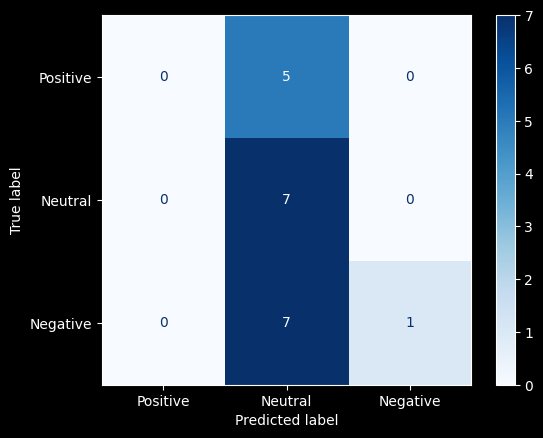

In [101]:
from sklearn.metrics import accuracy_score, classification_report

# Predict on the test set
y_pred = svm_model.predict(x_test)
# Evaluate the performance
def display_confusion_matrix(trueLabels, predictedLabels):
    cm = confusion_matrix(trueLabels, predictedLabels)
    labelsDisplay = ["Positive", "Neutral", "Negative"]
    plt.style.use('dark_background')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labelsDisplay)
    disp.plot(cmap='Blues')
display_confusion_matrix(y_test, y_pred)

Comme on peut le voir, les performances sont très médiocre, le modèle prédit presque systématiquement Neutre ce qui le rend d'une utilité quasi nulle pour prédire le ton sur les autres articles

Essayons maintenant d'utiliser ce modèle https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment?library=transformers

In [102]:
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

Contrairement au modèle SVM il faut donner le texte brut aux modèles basé sur roBERTa

In [103]:
with fs.open(f"{path}/ManuallyLabelledArticles.csv") as f:
    labelled = pd.read_csv(f)
print(labelled.head())
print(labelled.shape)

       ID                     Title     Date  \
0   87446    Imperial Valley press.  1944-11   
1  133641  The Daily Alaska empire.  1935-09   
2   24042             Smyrna times.  1955-09   
3   37164             Evening star.  1934-06   
4   29819     The Washington times.  1934-05   

                                             Article     Label  
0  Here Gre 8 big reasons for buying tho\nsanst y...  Positive  
1  Designed to bring the farm program within the\...   Neutral  
2  A federal bearing to determine\nwhether the mi...   Neutral  
3  By the Associated Press.\n\n\nMembership in th...  Positive  
4  1--WE.\n\n\nThese three phases are not un-\nre...  Negative  
(100, 5)


On étiquette differement que précédement pour se conformer aux notations du modèles

Ensuite comme les articles peuvent être long nous allons autoriser le tokenizer à tronquer les articles, l'idée est que les informations les plus importantes sont au début de l'article, ce n'est pas idéal et il faut garder cette hypothèse à l'esprit lorsque nous considérerons nos résultats

In [104]:
labels=labelled["Label"]
texts=labelled["Article"]
def numerical_label_BERT(label):
    if label=="Positive":
        return 2
    elif label=="Neutral":
        return 1
    else:
        return 0
tokenNumber=512
labels=labels.apply(numerical_label_BERT)
texts=tokenizer(texts.tolist(),max_length=tokenNumber, truncation=True, padding=True, return_tensors="pt")
input_ids = texts['input_ids'] #input_ids correspond aux textes tokenizer et numérisés
attention_mask = texts['attention_mask'] #attention_mask permet de savoir quels tokens sont des vrais tokens et lesquels sont des tokens de padding (le padding étant des tokens dummys pour avoir des séquences de la même taille)
print(input_ids)
print(input_ids.shape)

tensor([[    0, 11773,  6879,  ...,     1,     1,     1],
        [    0, 28324,  9044,  ...,     8,    25,     2],
        [    0,   250,   752,  ...,     1,     1,     1],
        ...,
        [    0, 19058,     5,  ..., 13247,    55,     2],
        [    0, 25767, 20048,  ...,     1,     1,     1],
        [    0, 12778,   548,  ...,     1,     1,     1]])
torch.Size([100, 512])


Maintenant il faut séparer les données en train et test

In [105]:
x_train, x_test, y_train, y_test,x_train_mask, x_test_mask = train_test_split(input_ids, labels, attention_mask, test_size=0.2, random_state=42)

In [106]:
import torch
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.input_ids[idx]),
            'attention_mask': torch.tensor(self.attention_mask[idx]),
            'labels': torch.tensor(self.labels[idx]),
        }

    def __len__(self):
        return len(self.labels)

train_dataset = NewsDataset(x_train.tolist(), x_train_mask.tolist(), y_train.tolist())
test_dataset = NewsDataset(x_test.tolist(), x_test_mask.tolist(), y_test.tolist())
print(train_dataset.input_ids)
print(train_dataset.labels)

[[0, 6905, 673, 13693, 13693, 13693, 1780, 257, 255, 38266, 462, 13693, 255, 11935, 7694, 1046, 50118, 26715, 137, 10, 1198, 12, 43222, 1053, 50118, 41587, 8371, 1757, 42, 76, 4, 635, 50118, 102, 981, 1172, 4, 446, 9109, 50118, 21651, 1571, 5337, 1896, 4, 26, 37, 50118, 1073, 13448, 19, 427, 7586, 31117, 14, 50118, 34451, 10, 367, 107, 5, 247, 50118, 7424, 3042, 10, 496, 4195, 50118, 1116, 23221, 6, 10742, 6, 727, 151, 10, 76, 4, 152, 50118, 354, 10, 1998, 55, 87, 5, 1455, 50118, 2279, 5564, 731, 4, 50140, 50118, 31602, 397, 30824, 1054, 3243, 5, 50118, 18691, 24049, 8, 27088, 36886, 50118, 859, 242, 38412, 19, 3356, 1655, 50118, 1116, 5, 1112, 4090, 1674, 50118, 179, 6177, 3500, 220, 76, 31, 50118, 12465, 9, 5, 2016, 29777, 2556, 4, 50118, 4528, 33, 5049, 7, 251, 50118, 9435, 9, 1964, 31, 856, 4668, 7, 652, 50118, 42289, 6, 8, 217, 4240, 102, 12, 50118, 1054, 18688, 8, 4372, 4, 50140, 50118, 10980, 7586, 31117, 553, 13, 8189, 50118, 10643, 5, 290, 228, 715, 28994, 15, 14592, 50118, 28

In [107]:


def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }   

training_args = TrainingArguments(
    output_dir='./results', 
    num_train_epochs=3, 
    per_device_train_batch_size=4, 
    per_device_eval_batch_size=4,
    logging_dir='./logs',
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)



In [108]:
trainer.train()

100%|██████████| 60/60 [04:41<00:00,  4.69s/it]

{'train_runtime': 281.6135, 'train_samples_per_second': 0.852, 'train_steps_per_second': 0.213, 'train_loss': 0.9105265935262045, 'epoch': 3.0}


TrainOutput(global_step=60, training_loss=0.9105265935262045, metrics={'train_runtime': 281.6135, 'train_samples_per_second': 0.852, 'train_steps_per_second': 0.213, 'total_flos': 63147220254720.0, 'train_loss': 0.9105265935262045, 'epoch': 3.0})

In [109]:
predictions_test=trainer.predict(test_dataset) # predict revoie les probabilités pour chaque classe
rawPreds=predictions_test.predictions
preds=rawPreds.argmax(-1)

100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


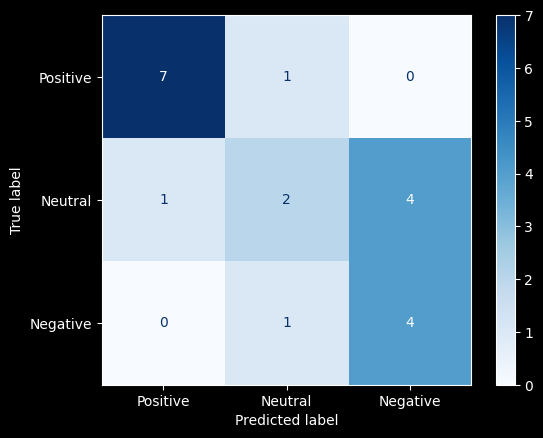

In [110]:
display_confusion_matrix(y_test, preds)

Les performances sont plutôt satisfantes ou au moins utilisable sur le peu de données que l'on a à dispostion, les neutrals ne sont pas très bien détectés mais le modèle apporte tout de même une plue value

In [116]:
corpus=articlesInflationSur["Article"]
tokens=tokenizer(corpus.tolist(),max_length=tokenNumber, truncation=True, padding=True, return_tensors="pt")

In [117]:
print(tokens)
dummyLabels=[0 for i in torch.zeros(tokens['input_ids'].shape[0]).tolist()]
print(dummyLabels)



{'input_ids': tensor([[    0,  4030,  4942,  ...,     1,     1,     1],
        [    0, 22247,     6,  ...,     1,     1,     1],
        [    0, 22247,     4,  ...,     1,     1,     1],
        ...,
        [    0,   133,   265,  ..., 25911, 20772,     2],
        [    0, 34437,  7300,  ..., 50118, 14596,     2],
        [    0,   510,  2068,  ...,     1,     1,     1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]])}
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
predictionsCorpus=trainer.predict(NewsDataset(tokens['input_ids'], tokens['attention_mask'], dummyLabels))

C:\Users\rapam\AppData\Local\Temp\ipykernel_18980\3378888420.py:10: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

C:\Users\rapam\AppData\Local\Temp\ipykernel_18980\3378888420.py:11: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

  2%|▏         | 276/14085 [04:07<3:32:32,  1.08it/s]

In [115]:
print(predictionsCorpus)

PredictionOutput(predictions=array([[-2.373533  ,  0.48115712,  2.1964478 ],
       [-1.713846  ,  1.9510344 , -0.12123814],
       [-2.62175   ,  1.9273759 ,  0.83656156],
       ...,
       [ 0.49580306,  0.25239092, -0.7007966 ],
       [ 0.42194647,  0.33976746, -0.68978393],
       [-2.0451827 ,  2.0278795 ,  0.05129389]], dtype=float32), label_ids=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
# Création de la variable catégorielle labels

In [ ]:
# Transformation des dates en format date
articlesInflationSur['date'] = pd.to_datetime(articlesInflationSur['Date'])

# Fusion des dataframes avec inflation quantitative et l'analyse de sentiment
inf_sent=pd.merge(inf_freq[["date", "year", "month", "inf_an", "inf_qu"]], articlesInflationSur, on=['date'])

In [108]:
inf=["Inflation: Quartile 1", "Inflation: Quartile 2", "Inflation: Quartile 3", "Inflation: Quartile 4"]
senti=["Négatif", "Neutre", "Positif"]
comp=quart_df(inf, senti, 4, 3, inf_sent("inf_qu"), inf_sent("labels"), inf_sent)

# Création de la heatmap
heatmap(
    comp,
    "Sentiments",
    "Inflation",
    "Nb observations",
    "Figure 15: Croisement des quartiles d'inflation (en valeur absolue) et des labels de sentiments"
)


C:\Users\lisem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\formatters.py:347: FutureWarning:

Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.

C:\Users\lisem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\formatters.py:347: FutureWarning:

RangeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.



,date,value,year,month,inf_an,inf_neg,acceleration_12,nbre_articles,cost,money,increase,market,prices,wages,economy,decrease,currency,cost of living,recession,purchasing power,cpi,price level,interest rates,market prices,inflation,cost_rat,money_rat,increase_rat,market_rat,prices_rat,wages_rat,economy_rat,decrease_rat,currency_rat,cost of living_rat,recession_rat,purchasing power_rat,cpi_rat,price level_rat,interest rates_rat,market prices_rat,inflation_rat,total_rat,inf_ma,tot_rat_ma,tot_rat_qu,inf_qu
0,1919-01-01,16.5,1919,1,17.857143,0,NaN,228632,8523,9151,6747,5859,5359,2040,531,921,292,396,49,54,138,50,36,79,3,3.727825,4.002502,2.951030,2.562633,2.343941,0.892264,0.232251,0.402831,0.127716,0.173204,0.021432,0.023619,0.060359,0.021869,0.015746,0.034553,0.001312,17.595087,NaN,NaN,4,4
1,1919-02-01,16.2,1919,2,14.893617,0,NaN,195555,7521,8202,5128,4970,4671,1946,468,620,270,339,59,43,94,45,31,71,0,3.845977,4.194216,2.622280,2.541484,2.388586,0.995116,0.239319,0.317046,0.138069,0.173353,0.030171,0.021989,0.048068,0.023011,0.015852,0.036307,0.000000,17.630846,NaN,NaN,4,4
2,1919-03-01,16.4,1919,3,17.142857,0,NaN,234087,8410,9873,5867,5786,5284,1969,522,704,408,362,77,48,120,60,47,83,3,3.592681,4.217663,2.506333,2.471731,2.257280,0.841140,0.222994,0.300743,0.174294,0.154643,0.032894,0.020505,0.051263,0.025631,0.020078,0.035457,0.001282,16.926613,NaN,NaN,3,4
3,1919-04-01,16.7,1919,4,17.605634,0,NaN,245278,8771,9725,6198,6031,5773,2016,527,689,301,267,127,55,100,77,39,119,1,3.575942,3.964889,2.526929,2.458843,2.353656,0.821925,0.214858,0.280906,0.122718,0.108856,0.051778,0.022424,0.040770,0.031393,0.015900,0.048516,0.000408,16.640710,NaN,NaN,3,4
4,1919-05-01,16.9,1919,5,16.551724,0,NaN,243206,8401,9259,5621,5768,5014,1567,506,598,269,275,80,54,90,61,22,55,3,3.454273,3.807061,2.311209,2.371652,2.061627,0.644310,0.208054,0.245882,0.110606,0.113073,0.032894,0.022203,0.037006,0.025082,0.009046,0.022615,0.001234,15.477825,NaN,NaN,2,4


In [ ]:
# Test du chi2
chi_test(comp)

In [ ]:
# Test de corrélation bisériale ponctuelle
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pointbiserialr.html
# Il faut transformer en variable binaire comme c'est du local: 1 si on est à cette modalité, 0 sinon, pour les trois modalités

pointbiserialr(var1, var2)